### Fitting a Generalized Extreme Value Distribution Model on SWM inner/outer diameters

In [5]:
import pymc as pm
import pymc_experimental as pmx
import arviz as az
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import genextreme
from sklearn.linear_model import LinearRegression
import matplotlib.ticker as ticker
from scipy.stats import gaussian_kde
from matplotlib.ticker import FuncFormatter
%matplotlib inline
plt.rcParams['figure.dpi'] = 300

def calculate_connection_velocity_rushton(axon_diameter, gratio):
    velocity = axon_diameter*((np.log(1/gratio))**0.68)*7.5 # factor 7.5 and exponent 0.68 according to Schmidt & Knösche, 2019
    return velocity

def z_score_dataframe(dataframe):
    """
    Z-scores a Pandas DataFrame.

    Parameters:
        dataframe (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: The z-scored DataFrame.
    """
    z_scored_dataframe = (dataframe - dataframe.mean()) / dataframe.std(ddof=0)
    return z_scored_dataframe

In [6]:
# Get SWM data
data_swm_1 = pd.read_csv(r"SWM\3_postprocessed\all_results_parallel_anonymized.csv")
data_swm_2 = pd.read_csv(r"SWM\3_postprocessed\all_results_orthogonal_anonymized.csv")
# Get CC data
data_cc = pd.read_csv(r"CC\3_postprocessed\all_results_CC_anonymized.csv")


In [7]:
data_swm = pd.concat([data_swm_1,data_swm_2])

In [8]:
# Here, we calculate the fraction below .65 for the comparison to the data by Raschke et al, 2008
cc_count_below_65 = (data_cc['inner_axis_minor_length'] < 0.65).sum()
swm_count_below_65 = (data_swm['inner_axis_minor_length'] < 0.65).sum()
cc_fraction_below_65 = cc_count_below_65/len(data_cc['inner_axis_minor_length'])
swm_fraction_below_65 = swm_count_below_65/len(data_swm['inner_axis_minor_length'])
print(f"Fraction of axons below .65µm in CC: {cc_fraction_below_65}")
print(f"Fraction of axons below .65µm in SWM: {swm_fraction_below_65}")

Fraction of axons below .65µm in CC: 0.7490830735375023
Fraction of axons below .65µm in SWM: 0.7490830735375023


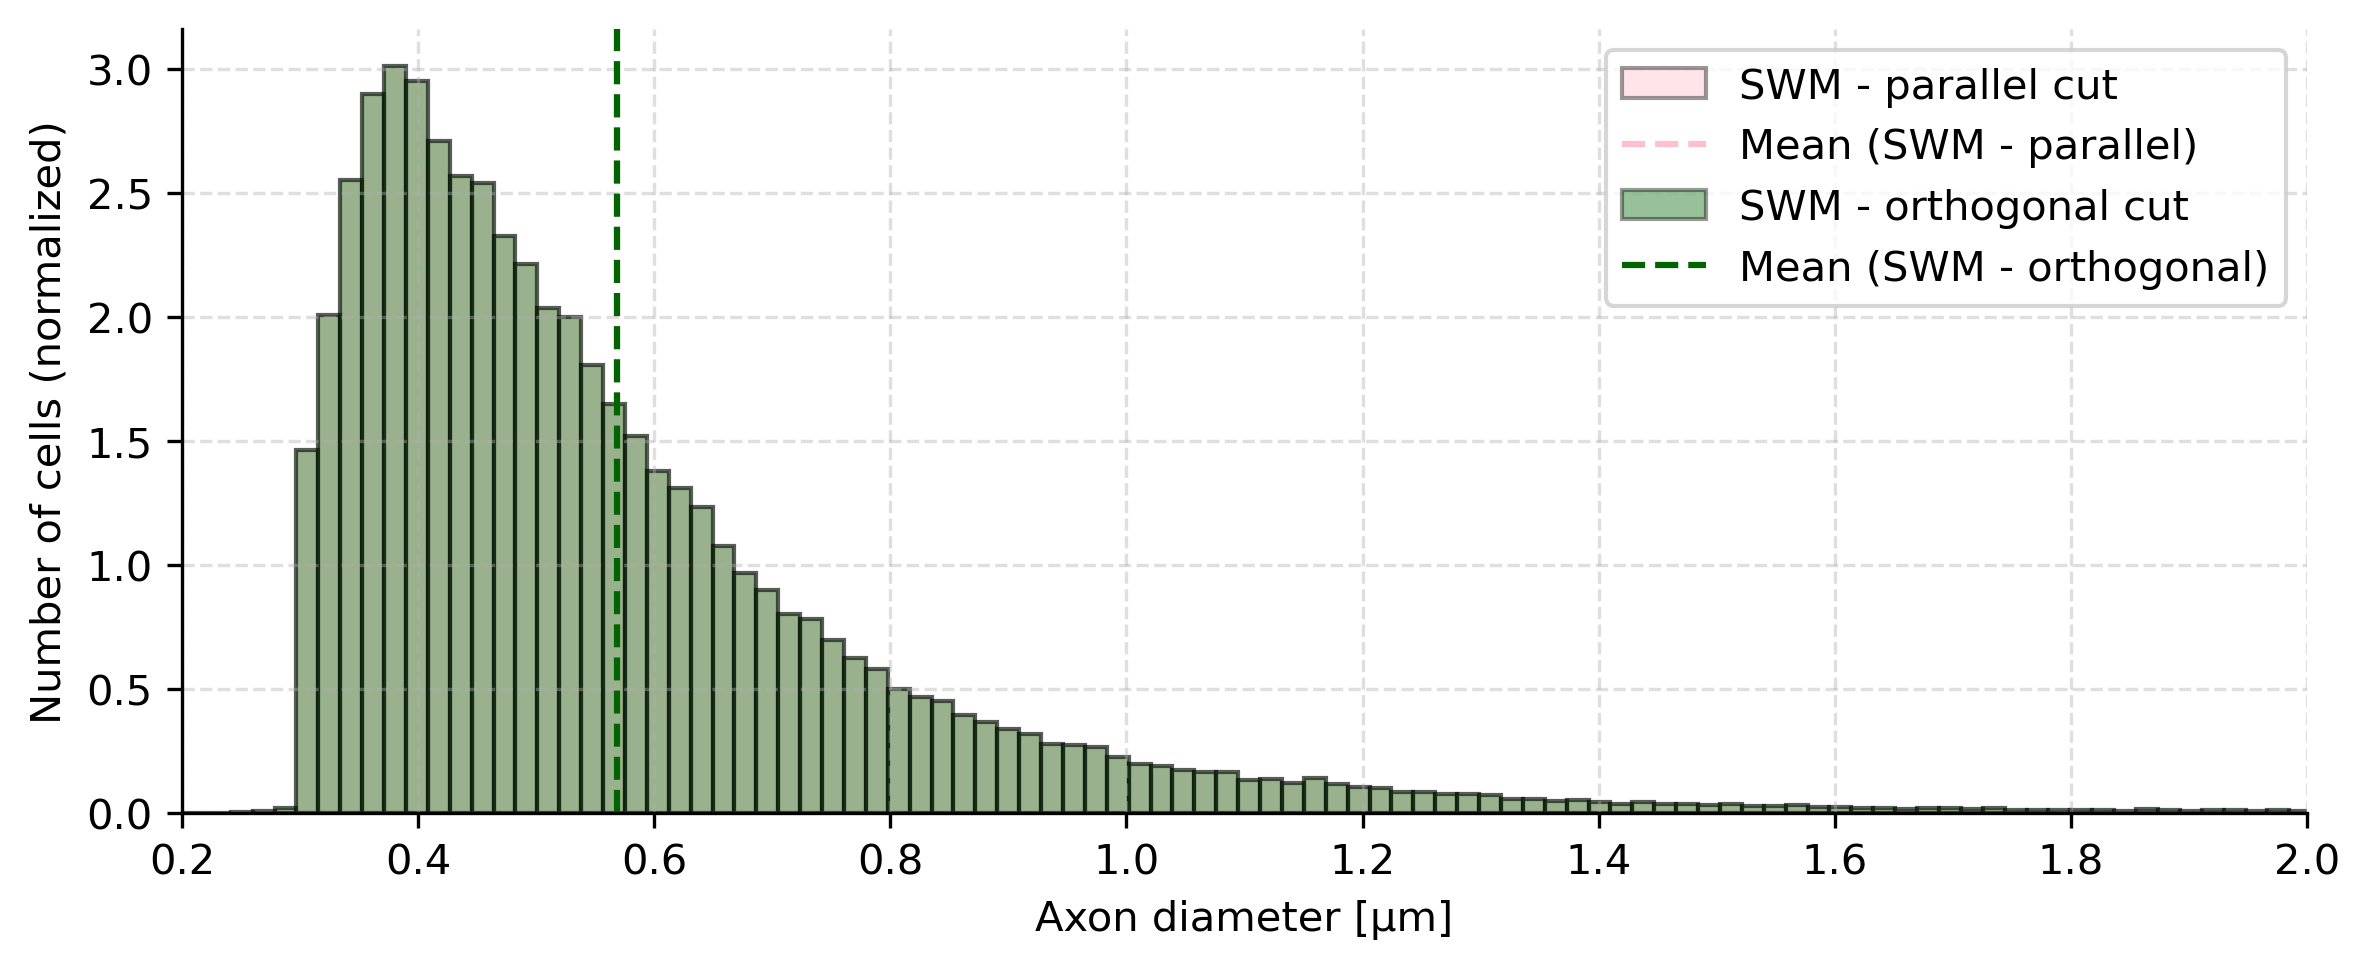

Mean axon Diameter (SWM - parallel): 0.5685077256356343
Mean axon Diameter (SWM - orthogonal): 0.5685077256356343
Ratio SWM/CC: 1.0


In [9]:
# visualize raw data of orthogonally vs parallel cut axons
fig, ax = plt.subplots(figsize=(8, 5*2/3))

bins = np.linspace(min(min(data_swm['inner_axis_minor_length']), min(data_cc['inner_axis_minor_length'])),
                   max(max(data_swm['inner_axis_minor_length']), max(data_cc['inner_axis_minor_length'])), 250)

# Plot parallel cut data
ax.hist(data_swm_1['inner_axis_minor_length'], bins=bins, edgecolor='black', color='pink', alpha=0.4, label='SWM - parallel cut', density=True)
ax.axvline(data_swm_1['inner_axis_minor_length'].mean(), color='pink', linestyle='--', label='Mean (SWM - parallel)')

# Plot orthogonally cut data
ax.hist(data_swm_2['inner_axis_minor_length'], bins=bins, edgecolor='black', color='darkgreen', alpha=0.4, label='SWM - orthogonal cut', density=True)
ax.axvline(data_swm_2['inner_axis_minor_length'].mean(), color='darkgreen', linestyle='--', label='Mean (SWM - orthogonal)')

# Customize plot elements
ax.set_ylabel('Number of cells (normalized)')
ax.set_xlabel('Axon diameter [µm]')
ax.set_xlim(0.2,2)
ax.grid(True, linestyle='--', alpha=0.4, which='both')
ax.legend()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

print(f"Mean axon Diameter (SWM - parallel): {data_swm_1['inner_axis_minor_length'].mean()}")
print(f"Mean axon Diameter (SWM - orthogonal): {data_swm_2['inner_axis_minor_length'].mean()}")
print(f"Ratio SWM/CC: {data_swm_1['inner_axis_minor_length'].mean()/data_swm_2['inner_axis_minor_length'].mean()}")


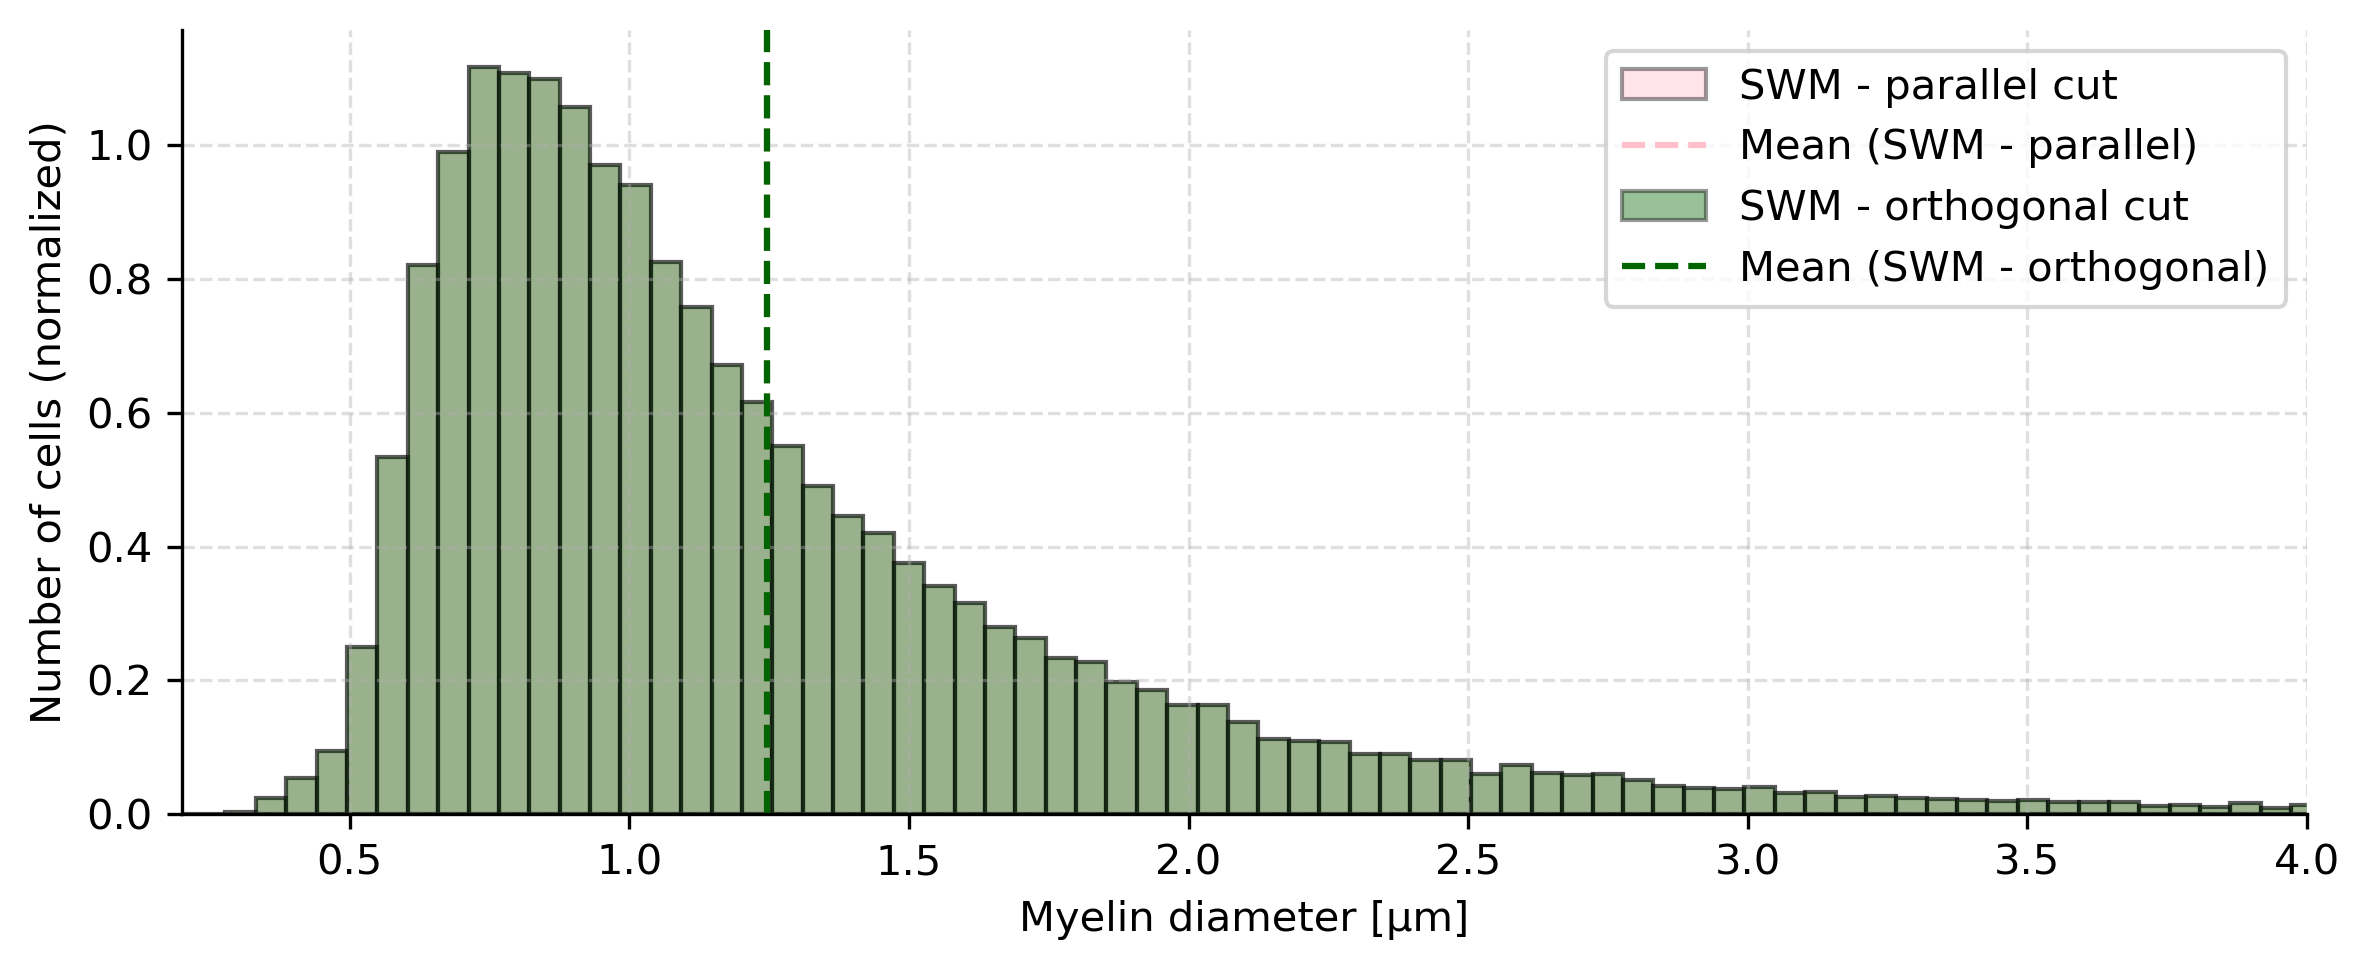

Mean myelin Diameter (SWM - parallel): 1.2457797796428287
Mean myelin Diameter (SWM - orthogonal): 1.2457797796428287
Ratio SWM/CC: 1.0


In [10]:
# visualize raw data of orthogonally vs parallel cut axons
fig, ax = plt.subplots(figsize=(8, 5*2/3))

bins = np.linspace(min(min(data_swm['outer_axis_minor_length']), min(data_cc['outer_axis_minor_length'])),
                   max(max(data_swm['outer_axis_minor_length']), max(data_cc['outer_axis_minor_length'])), 250)

# Plot parallel cut data
ax.hist(data_swm_1['outer_axis_minor_length'], bins=bins, edgecolor='black', color='pink', alpha=0.4, label='SWM - parallel cut', density=True)
ax.axvline(data_swm_1['outer_axis_minor_length'].mean(), color='pink', linestyle='--', label='Mean (SWM - parallel)')

# Plot orthogonally cut data
ax.hist(data_swm_2['outer_axis_minor_length'], bins=bins, edgecolor='black', color='darkgreen', alpha=0.4, label='SWM - orthogonal cut', density=True)
ax.axvline(data_swm_2['outer_axis_minor_length'].mean(), color='darkgreen', linestyle='--', label='Mean (SWM - orthogonal)')

# Customize plot elements
ax.set_ylabel('Number of cells (normalized)')
ax.set_xlabel('Myelin diameter [µm]')
ax.set_xlim(0.2,4)
ax.grid(True, linestyle='--', alpha=0.4, which='both')
ax.legend()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

print(f"Mean myelin Diameter (SWM - parallel): {data_swm_1['outer_axis_minor_length'].mean()}")
print(f"Mean myelin Diameter (SWM - orthogonal): {data_swm_2['outer_axis_minor_length'].mean()}")
print(f"Ratio SWM/CC: {data_swm_1['outer_axis_minor_length'].mean()/data_swm_2['outer_axis_minor_length'].mean()}")


c:\Users\Hoellenmaschine2\anaconda3\envs\pymc_env_3\Lib\site-packages\numpy\lib\histograms.py:885: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
c:\Users\Hoellenmaschine2\anaconda3\envs\pymc_env_3\Lib\site-packages\numpy\lib\histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


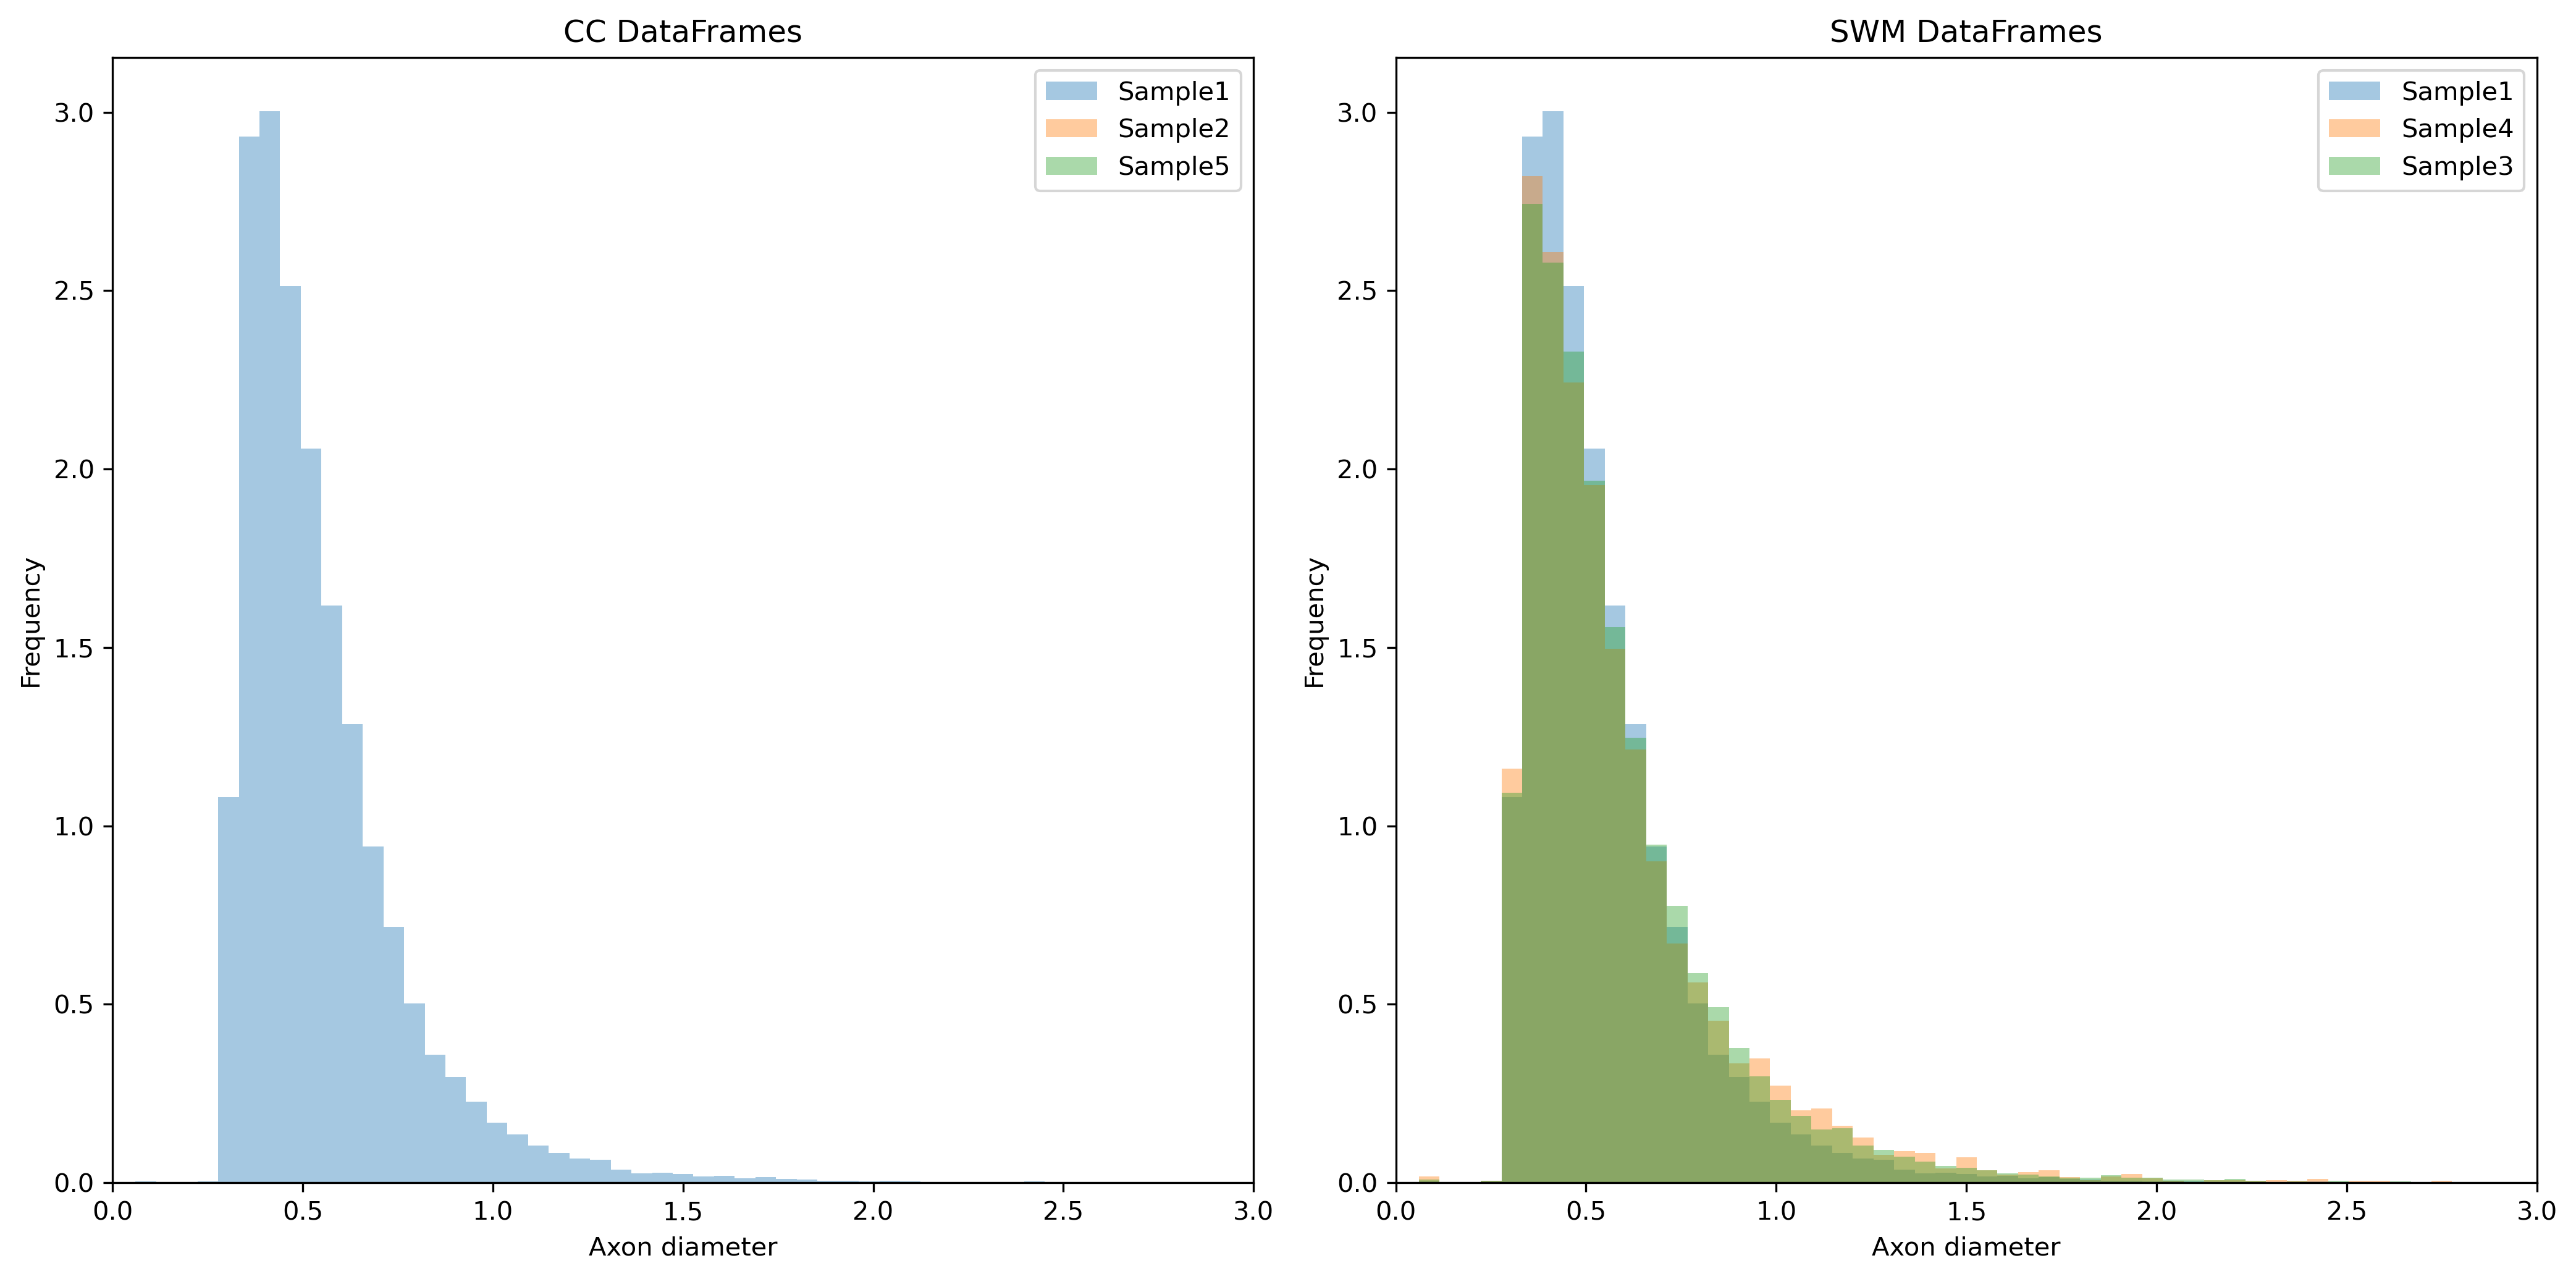

In [11]:
# Split dataframes according to individuals
data_cc_HH4 = data_cc[data_cc['file'].str.contains('Sample1')]
data_cc_1806 = data_cc[data_cc['file'].str.contains('Sample2')]
data_cc_2001 = data_cc[data_cc['file'].str.contains('Sample5')]
data_swm_HH4 = data_swm[data_swm['file'].str.contains('Sample1')]
data_swm_2202 = data_swm[data_swm['file'].str.contains('Sample4')]
data_swm_2201 = data_swm[data_swm['file'].str.contains('Sample3')]

# List of DataFrames and corresponding labels
cc_dataframes = [data_cc_HH4, data_cc_1806, data_cc_2001]
cc_labels = ["Sample1", "Sample2", "Sample5"]
swm_dataframes = [data_swm_HH4, data_swm_2202, data_swm_2201]
swm_labels = ["Sample1", "Sample4", "Sample3"]

# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

# Plot histograms for cc dataframes
for df, label in zip(cc_dataframes, cc_labels):
    axes[0].hist(df['inner_axis_minor_length'], bins=bins, alpha=0.4, label=label, density=True)

axes[0].set_title('CC DataFrames')
axes[0].set_xlabel('Axon diameter')
axes[0].set_ylabel('Frequency')
axes[0].set_xlim(0, 3)
axes[0].legend()

# Plot histograms for swm dataframes
for df, label in zip(swm_dataframes, swm_labels):
    axes[1].hist(df['inner_axis_minor_length'], bins=bins, alpha=0.4, label=label, density=True)

axes[1].set_title('SWM DataFrames')
axes[1].set_xlabel('Axon diameter')
axes[1].set_ylabel('Frequency')
axes[1].set_xlim(0, 3)
axes[1].legend()

plt.tight_layout()
plt.show()


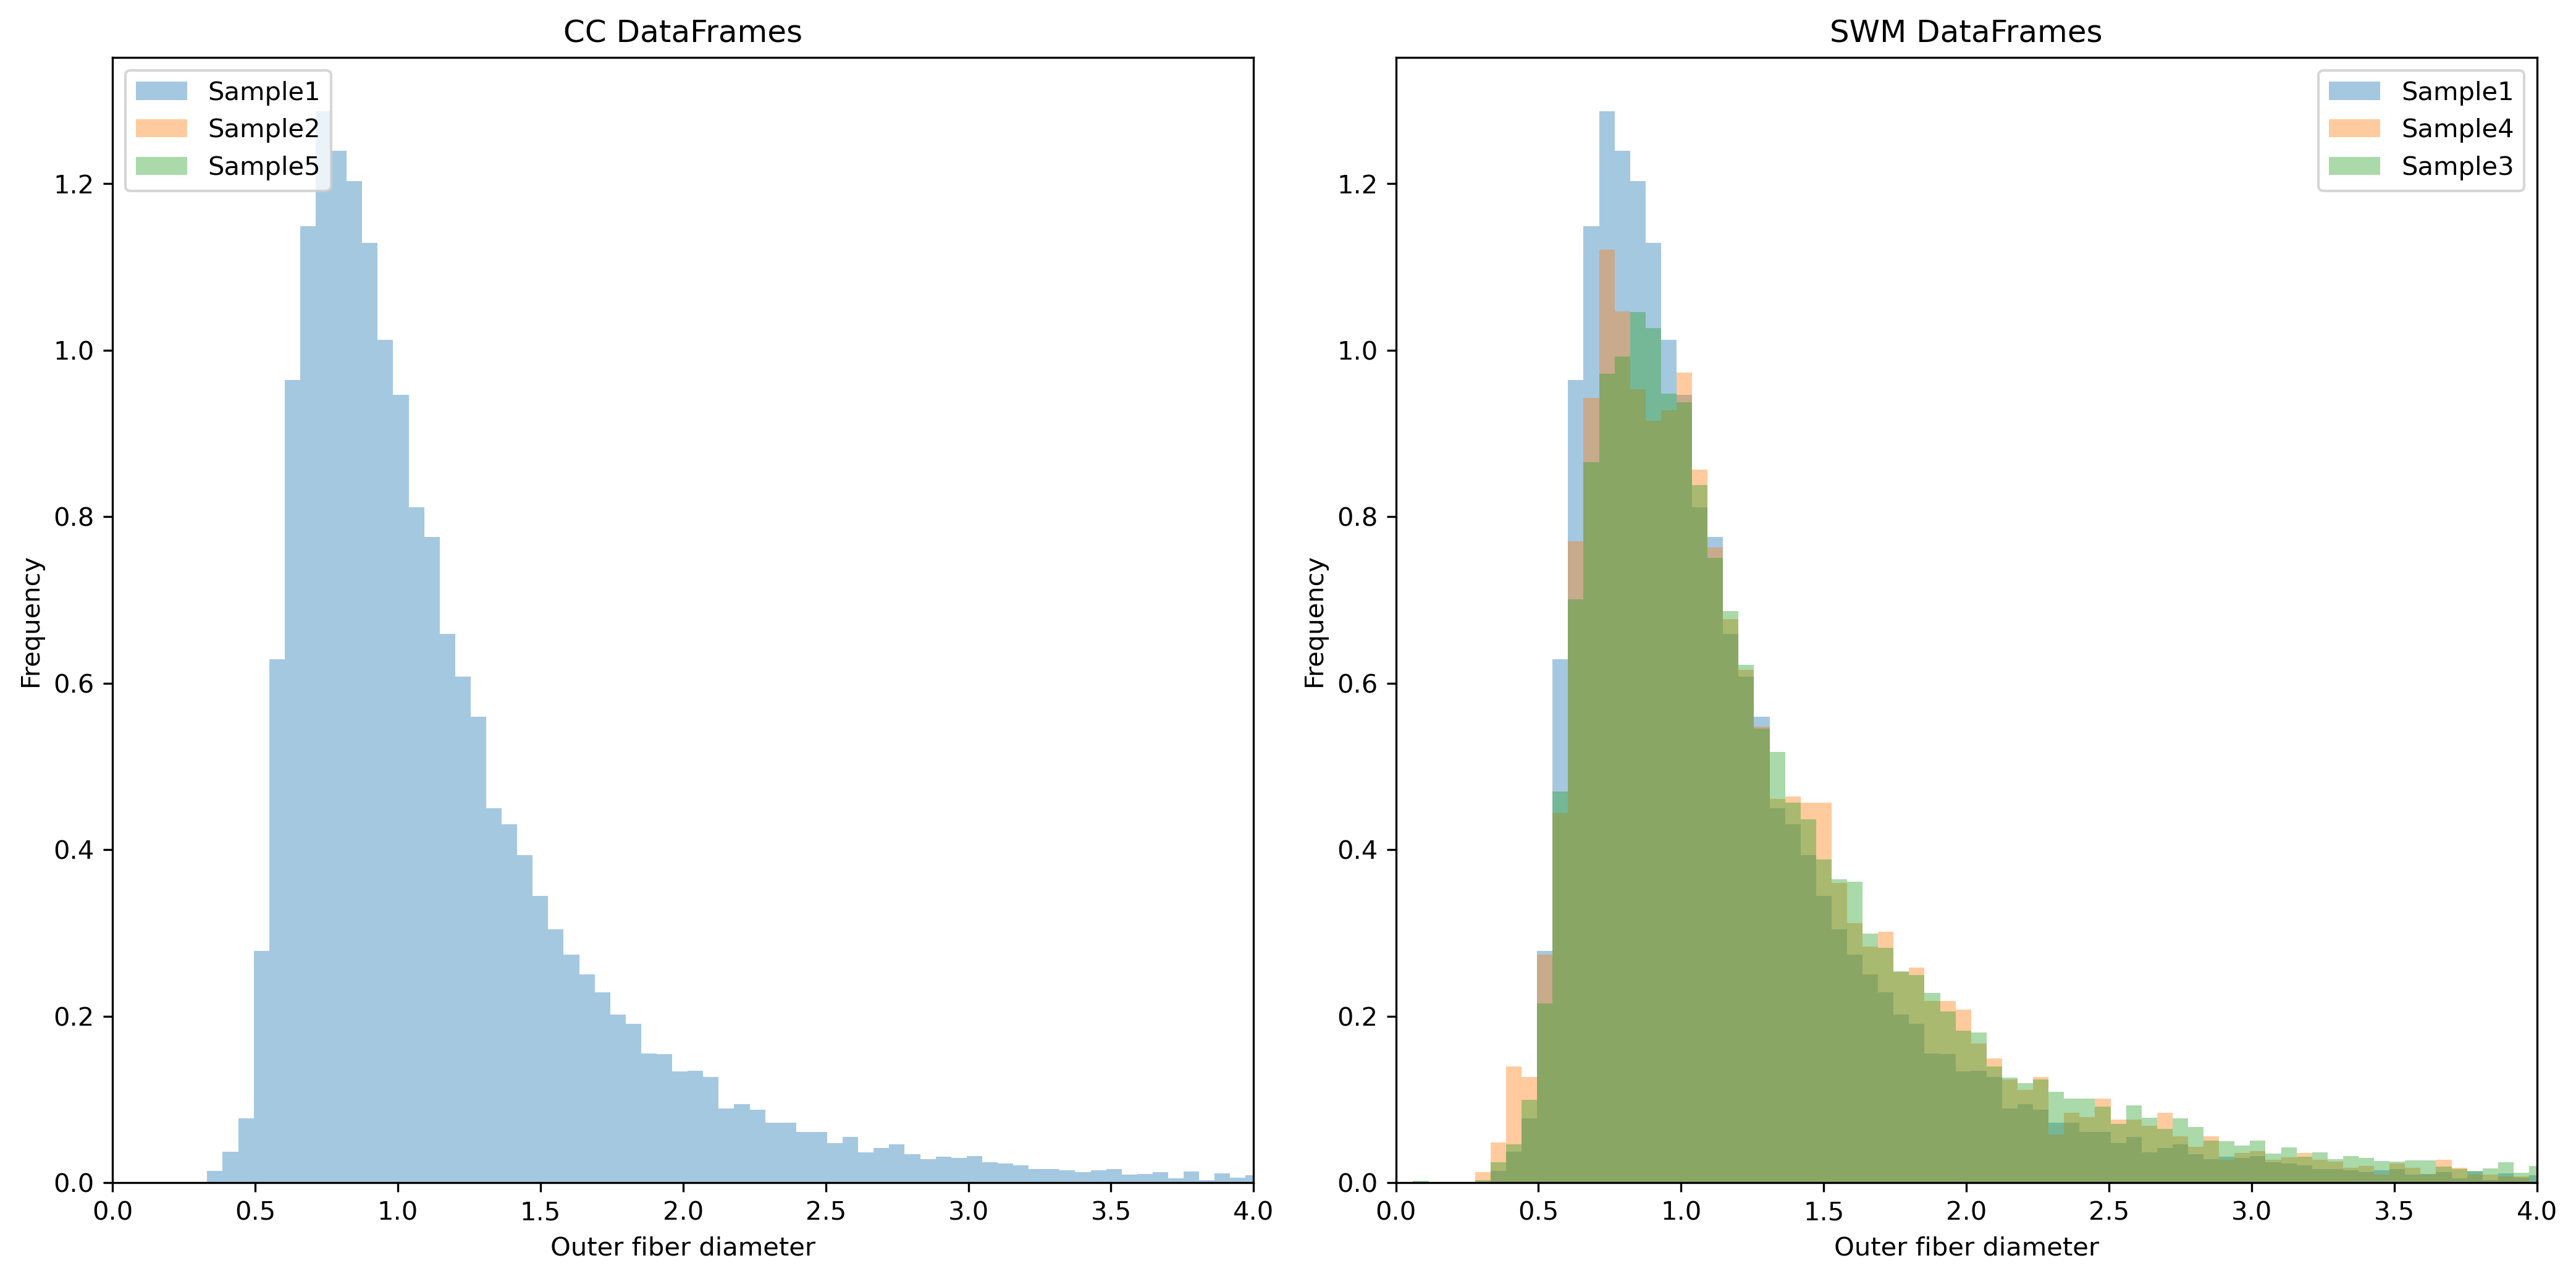

In [12]:
# Split dataframes according to individuals
data_cc_HH4 = data_cc[data_cc['file'].str.contains('Sample1')]
data_cc_1806 = data_cc[data_cc['file'].str.contains('Sample2')]
data_cc_2001 = data_cc[data_cc['file'].str.contains('Sample5')]
data_swm_HH4 = data_swm[data_swm['file'].str.contains('Sample1')]
data_swm_2202 = data_swm[data_swm['file'].str.contains('Sample4')]
data_swm_2201 = data_swm[data_swm['file'].str.contains('Sample3')]

# List of DataFrames and corresponding labels
cc_dataframes = [data_cc_HH4, data_cc_1806, data_cc_2001]
cc_labels = ["Sample1", "Sample2", "Sample5"]
swm_dataframes = [data_swm_HH4, data_swm_2202, data_swm_2201]
swm_labels = ["Sample1", "Sample4", "Sample3"]

# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

# Plot histograms for cc dataframes
for df, label in zip(cc_dataframes, cc_labels):
    axes[0].hist(df['outer_axis_minor_length'], bins=bins, alpha=0.4, label=label, density=True)

axes[0].set_title('CC DataFrames')
axes[0].set_xlabel('Outer fiber diameter')
axes[0].set_ylabel('Frequency')
axes[0].set_xlim(0, 4)
axes[0].legend()

# Plot histograms for swm dataframes
for df, label in zip(swm_dataframes, swm_labels):
    axes[1].hist(df['outer_axis_minor_length'], bins=bins, alpha=0.4, label=label, density=True)

axes[1].set_title('SWM DataFrames')
axes[1].set_xlabel('Outer fiber diameter')
axes[1].set_ylabel('Frequency')
axes[1].set_xlim(0, 4)
axes[1].legend()

plt.tight_layout()
plt.show()


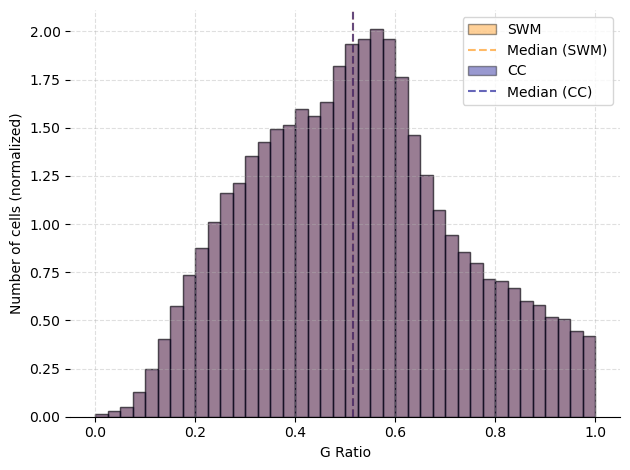

In [13]:
# plot g-ratio distributions
fig, ax = plt.subplots(dpi=100)

# Plot for swm
ax.hist(data_swm['gratio'], bins=40, edgecolor='black', color='darkorange', alpha=0.4, label='SWM', density=True)
ax.axvline(data_swm['gratio'].median(), color='darkorange', linestyle='--',alpha = 0.6, label='Median (SWM)')

# Plot for cc
ax.hist(data_cc['gratio'], bins=40, edgecolor='black', color='darkblue', alpha=0.4, label='CC', density=True)
ax.axvline(data_cc['gratio'].median(), color='darkblue', linestyle='--',alpha = 0.6, label='Median (CC)')

# Customize plot elements
ax.set_ylabel('Number of cells (normalized)')
ax.set_xlabel('G Ratio')
ax.grid(True, linestyle='--', alpha=0.4, which='both')
ax.legend()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [14]:
data_cc['gratio'].mean()

0.5189173402963481

In [15]:
data_swm['gratio'].mean()

0.5189173402963481

In [16]:
with pm.Model() as model:
    # Priors are taken from Nik's GEV fit to Corpus Callosum data.
    swm_mu_inner = pm.TruncatedNormal('swm_mu_inner', mu=0.55, sigma=0.1, lower=0.05,)
    swm_sigma_inner = pm.TruncatedNormal('swm_sigma_inner', mu=0.35, sigma=0.1, lower=0.001,)
    swm_xi_inner = pm.TruncatedNormal('swm_xi_inner', mu=0.25, sigma=0.15, lower=0, upper=0.5,)

    cc_mu_inner = pm.TruncatedNormal('cc_mu_inner', mu=0.55, sigma=0.1, lower=0.05,)
    cc_sigma_inner = pm.TruncatedNormal('cc_sigma_inner', mu=0.35, sigma=0.1, lower=0.001,)
    cc_xi_inner = pm.TruncatedNormal('cc_xi_inner', mu=0.25, sigma=0.15, lower=0, upper=0.5,)

    swm_y_inner_likelihood = pmx.distributions.GenExtreme('swm_inner', mu=swm_mu_inner, sigma=swm_sigma_inner, xi=swm_xi_inner, observed=data_swm["inner_axis_minor_length"])
    cc_y_inner_likelihood = pmx.distributions.GenExtreme('cc_inner', mu=cc_mu_inner, sigma=cc_sigma_inner, xi=cc_xi_inner, observed=data_cc["inner_axis_minor_length"])

    # Priors are estimated, given Nik's GEV fit to Corpus Callosum data.
    swm_mu_outer = pm.TruncatedNormal('swm_mu_outer', mu=1.0, sigma=0.1, lower=0.05,)
    swm_sigma_outer = pm.TruncatedNormal('swm_sigma_outer', mu=0.35, sigma=0.1, lower=0.001,)
    swm_xi_outer = pm.TruncatedNormal('swm_xi_outer', mu=0.28, sigma=0.15, lower=0, upper=0.5,)

    cc_mu_outer = pm.TruncatedNormal('cc_mu_outer', mu=1.0, sigma=0.1, lower=0.05,)
    cc_sigma_outer = pm.TruncatedNormal('cc_sigma_outer', mu=0.35, sigma=0.1, lower=0.001,)
    cc_xi_outer = pm.TruncatedNormal('cc_xi_outer', mu=0.28, sigma=0.15, lower=0, upper=0.5,)

    swm_y_outer_likelihood = pmx.distributions.GenExtreme('swm_outer', mu=swm_mu_outer, sigma=swm_sigma_outer, xi=swm_xi_outer, observed=data_swm["outer_axis_minor_length"])
    cc_y_outer_likelihood = pmx.distributions.GenExtreme('cc_outer', mu=cc_mu_outer, sigma=cc_sigma_outer, xi=cc_xi_outer, observed=data_cc["outer_axis_minor_length"])
    
    # deterministic variables
    swm_g_ratio = pm.Deterministic(f'swm_g_ratio',swm_y_inner_likelihood/swm_y_outer_likelihood)
    cc_g_ratio = pm.Deterministic(f'cc_g_ratio',cc_y_inner_likelihood/cc_y_outer_likelihood)

    diff_of_mu_inner = pm.Deterministic("difference of mu (fibers)", cc_mu_inner - swm_mu_inner)
    diff_of_sigma_inner = pm.Deterministic("difference of sigma (fibers)", cc_sigma_inner - swm_sigma_inner)
    diff_of_xi_inner = pm.Deterministic("difference of xi (fibers)", cc_xi_inner - swm_xi_inner)

    diff_of_mu_outer = pm.Deterministic("difference of mu (myelination)", cc_mu_outer - swm_mu_outer)
    diff_of_sigma_outer = pm.Deterministic("difference of sigma (myelination)", cc_sigma_outer - swm_sigma_outer)
    diff_of_xi_outer = pm.Deterministic("difference of xi (myelination)", cc_xi_outer - swm_xi_outer)

In [17]:
trace_prior = pm.sample_prior_predictive(samples=200, model=model,random_seed=42,)

Sampling: [cc_inner, cc_mu_inner, cc_mu_outer, cc_outer, cc_sigma_inner, cc_sigma_outer, cc_xi_inner, cc_xi_outer, swm_inner, swm_mu_inner, swm_mu_outer, swm_outer, swm_sigma_inner, swm_sigma_outer, swm_xi_inner, swm_xi_outer]


In [18]:
trace_prior

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

In [19]:
# extract GEV priors (inner, SWM)
swm_mu_inner_prior = az.extract_dataset(trace_prior.prior)["swm_mu_inner"].to_numpy()
swm_sigma_inner_prior = az.extract_dataset(trace_prior.prior)["swm_sigma_inner"].to_numpy()
swm_xi_inner_prior = az.extract_dataset(trace_prior.prior)["swm_xi_inner"].to_numpy()

# extract GEV priors (outer, SWM)
swm_mu_outer_prior = az.extract_dataset(trace_prior.prior)["swm_mu_outer"].to_numpy()
swm_sigma_outer_prior = az.extract_dataset(trace_prior.prior)["swm_sigma_outer"].to_numpy()
swm_xi_outer_prior = az.extract_dataset(trace_prior.prior)["swm_xi_outer"].to_numpy()

# extract GEV priors (inner, CC)
cc_mu_inner_prior = az.extract_dataset(trace_prior.prior)["cc_mu_inner"].to_numpy()
cc_sigma_inner_prior = az.extract_dataset(trace_prior.prior)["cc_sigma_inner"].to_numpy()
cc_xi_inner_prior = az.extract_dataset(trace_prior.prior)["cc_xi_inner"].to_numpy()

# extract GEV priors (outer, CC)
cc_mu_outer_prior = az.extract_dataset(trace_prior.prior)["cc_mu_outer"].to_numpy()
cc_sigma_outer_prior = az.extract_dataset(trace_prior.prior)["cc_sigma_outer"].to_numpy()
cc_xi_outer_prior = az.extract_dataset(trace_prior.prior)["cc_xi_outer"].to_numpy()

C:\Users\Hoellenmaschine2\AppData\Local\Temp\ipykernel_17872\3576262195.py:2: FutureWarning: extract_dataset has been deprecated, please use extract
  swm_mu_inner_prior = az.extract_dataset(trace_prior.prior)["swm_mu_inner"].to_numpy()
C:\Users\Hoellenmaschine2\AppData\Local\Temp\ipykernel_17872\3576262195.py:3: FutureWarning: extract_dataset has been deprecated, please use extract
  swm_sigma_inner_prior = az.extract_dataset(trace_prior.prior)["swm_sigma_inner"].to_numpy()
C:\Users\Hoellenmaschine2\AppData\Local\Temp\ipykernel_17872\3576262195.py:4: FutureWarning: extract_dataset has been deprecated, please use extract
  swm_xi_inner_prior = az.extract_dataset(trace_prior.prior)["swm_xi_inner"].to_numpy()
C:\Users\Hoellenmaschine2\AppData\Local\Temp\ipykernel_17872\3576262195.py:7: FutureWarning: extract_dataset has been deprecated, please use extract
  swm_mu_outer_prior = az.extract_dataset(trace_prior.prior)["swm_mu_outer"].to_numpy()
C:\Users\Hoellenmaschine2\AppData\Local\Temp\i

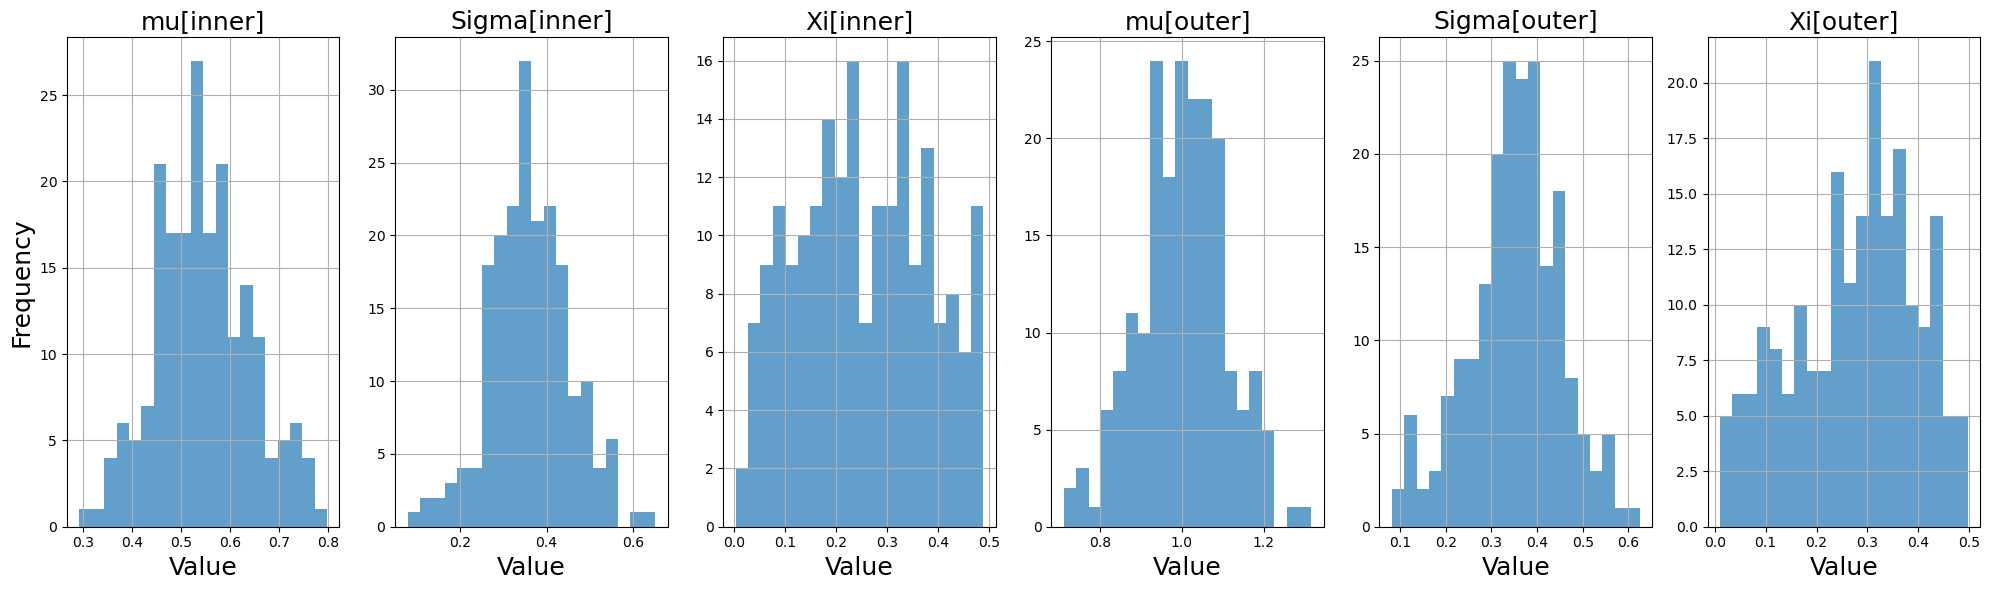

In [20]:
n_bins=20

# Create subplots of prior samples for SWM
fig, axes = plt.subplots(1, 6, figsize=(20, 6),dpi=100)
# Plot the histogram of beta_prior
axes[0].hist(swm_mu_inner_prior, bins=n_bins,alpha=0.7)
axes[0].set_title('mu[inner]',fontsize=18)
axes[0].set_xlabel('Value',fontsize=18)
axes[0].set_ylabel('Frequency',fontsize=18)
axes[0].grid(True)

# Plot the histogram of sigma_prior
axes[1].hist(swm_sigma_inner_prior, bins=n_bins, alpha=0.7)
axes[1].set_title('Sigma[inner]',fontsize=18)
axes[1].set_xlabel('Value',fontsize=18)
# axes[1].set_ylabel('Frequency')
axes[1].grid(True)

# Plot the histogram of xi_prior
axes[2].hist(swm_xi_inner_prior, bins=n_bins,alpha=0.7)
axes[2].set_title('Xi[inner]',fontsize=18)
axes[2].set_xlabel('Value',fontsize=18)
# axes[2].set_ylabel('Frequency')
axes[2].grid(True)

# Plot the histogram of mu_outer_prior
axes[3].hist(swm_mu_outer_prior, bins=n_bins,alpha=0.7)
axes[3].set_title('mu[outer]',fontsize=18)
axes[3].set_xlabel('Value',fontsize=18)
# axes[3].set_ylabel('Frequency')
axes[3].grid(True)

# Plot the histogram of sigma_outer_prior
axes[4].hist(swm_sigma_outer_prior, bins=n_bins,alpha=0.7)
axes[4].set_title('Sigma[outer]',fontsize=18)
axes[4].set_xlabel('Value',fontsize=18)
# axes[4].set_ylabel('Frequency')
axes[4].grid(True)

# Plot the histogram of xi_outer_prior
axes[5].hist(swm_xi_outer_prior, bins=n_bins,alpha=0.7)
axes[5].set_title('Xi[outer]',fontsize=18)
axes[5].set_xlabel('Value',fontsize=18)
# axes[5].set_ylabel('Frequency')
axes[5].grid(True)

plt.tight_layout()
plt.show()

In [21]:
trace_prior

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

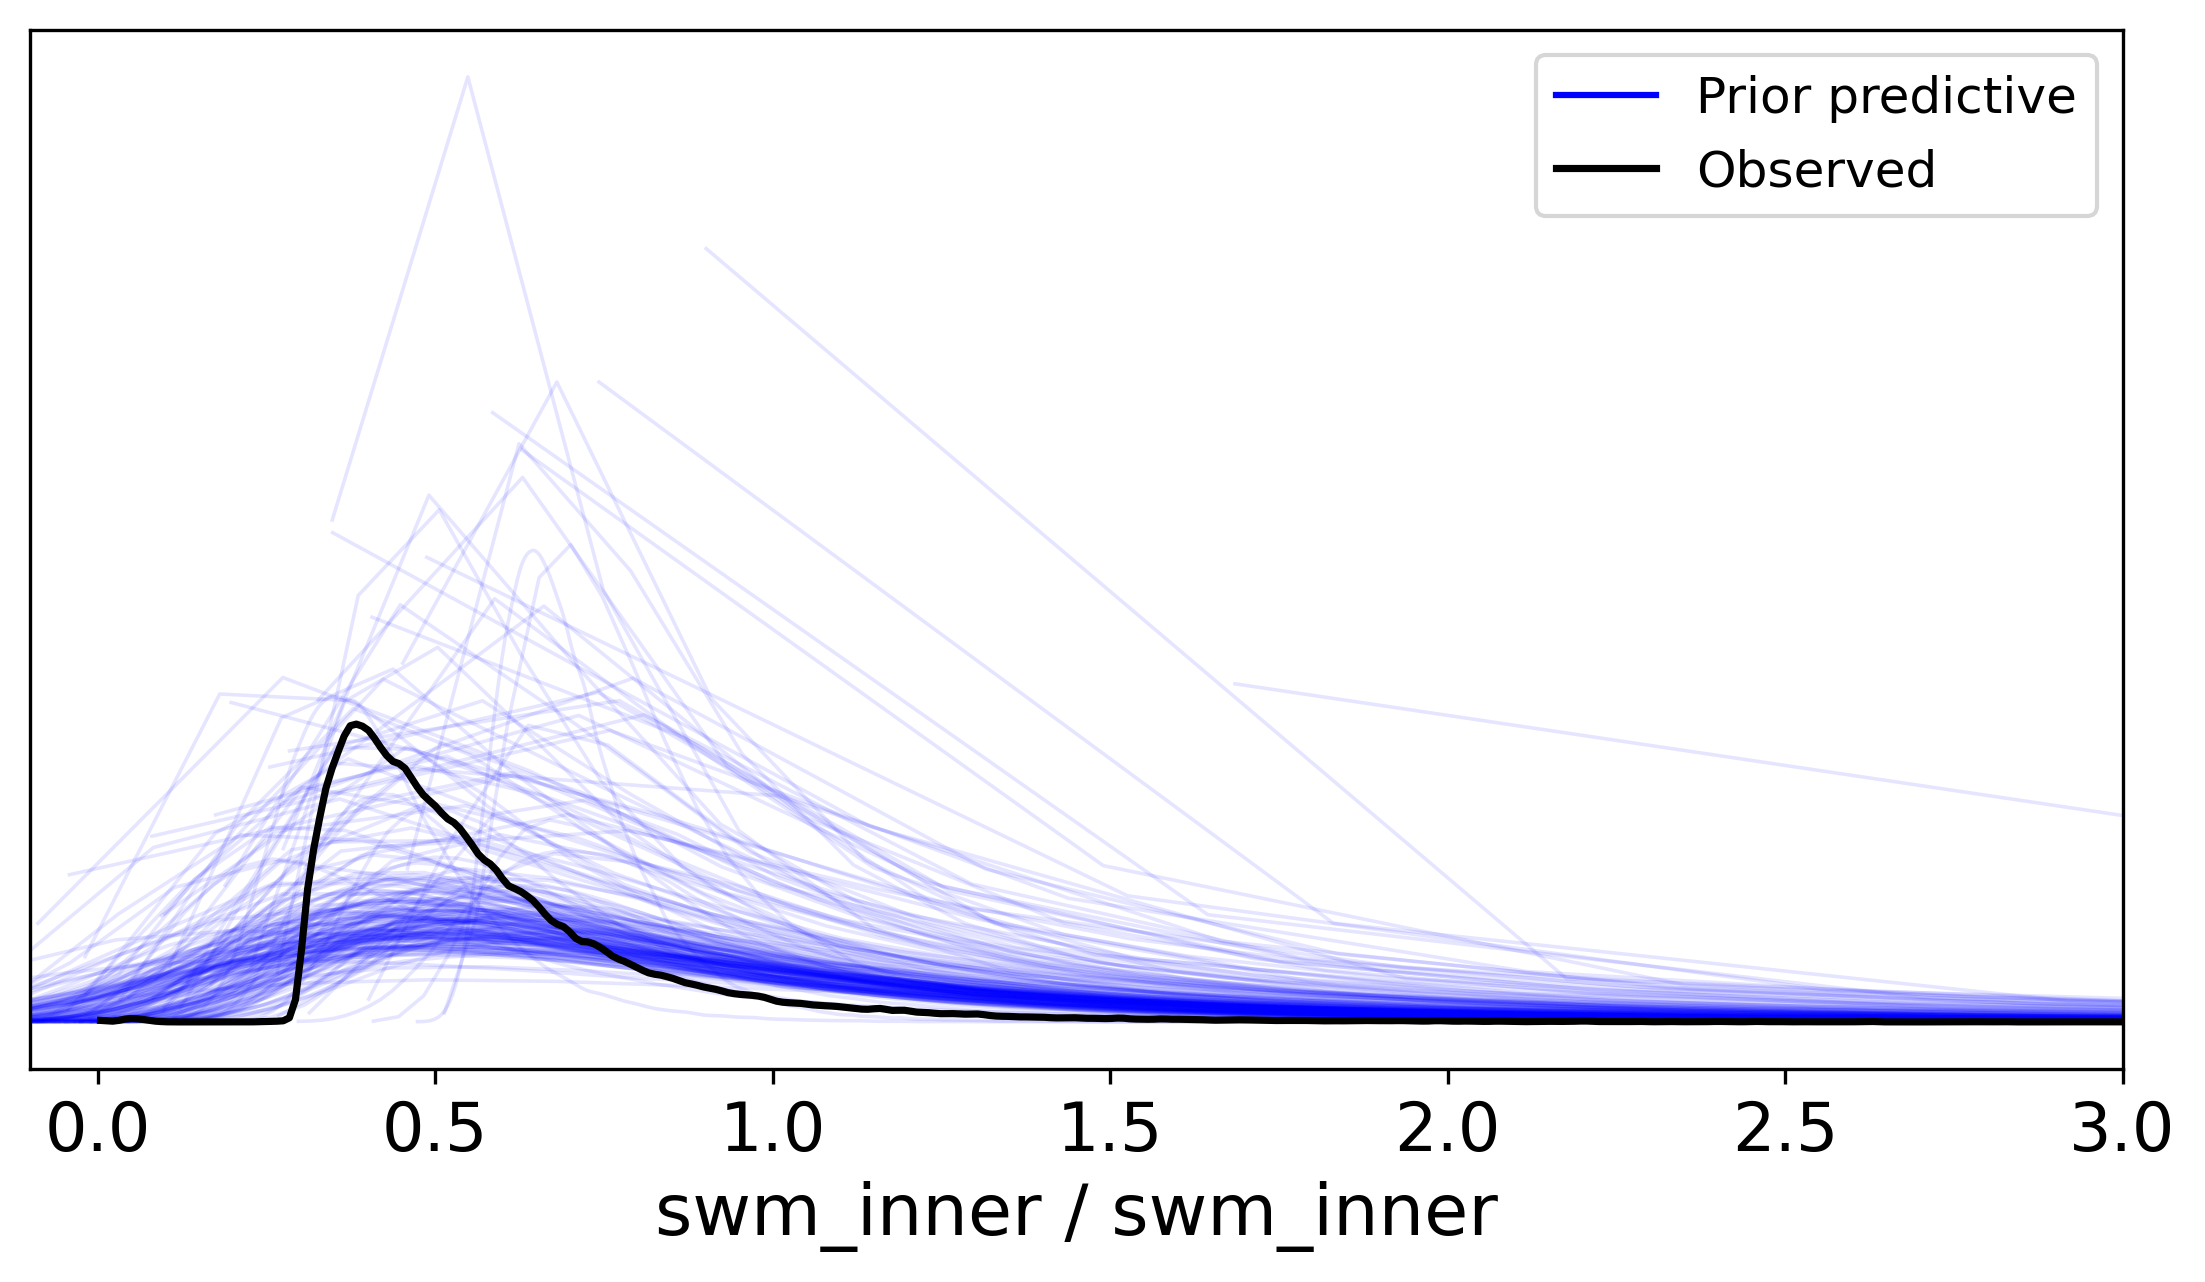

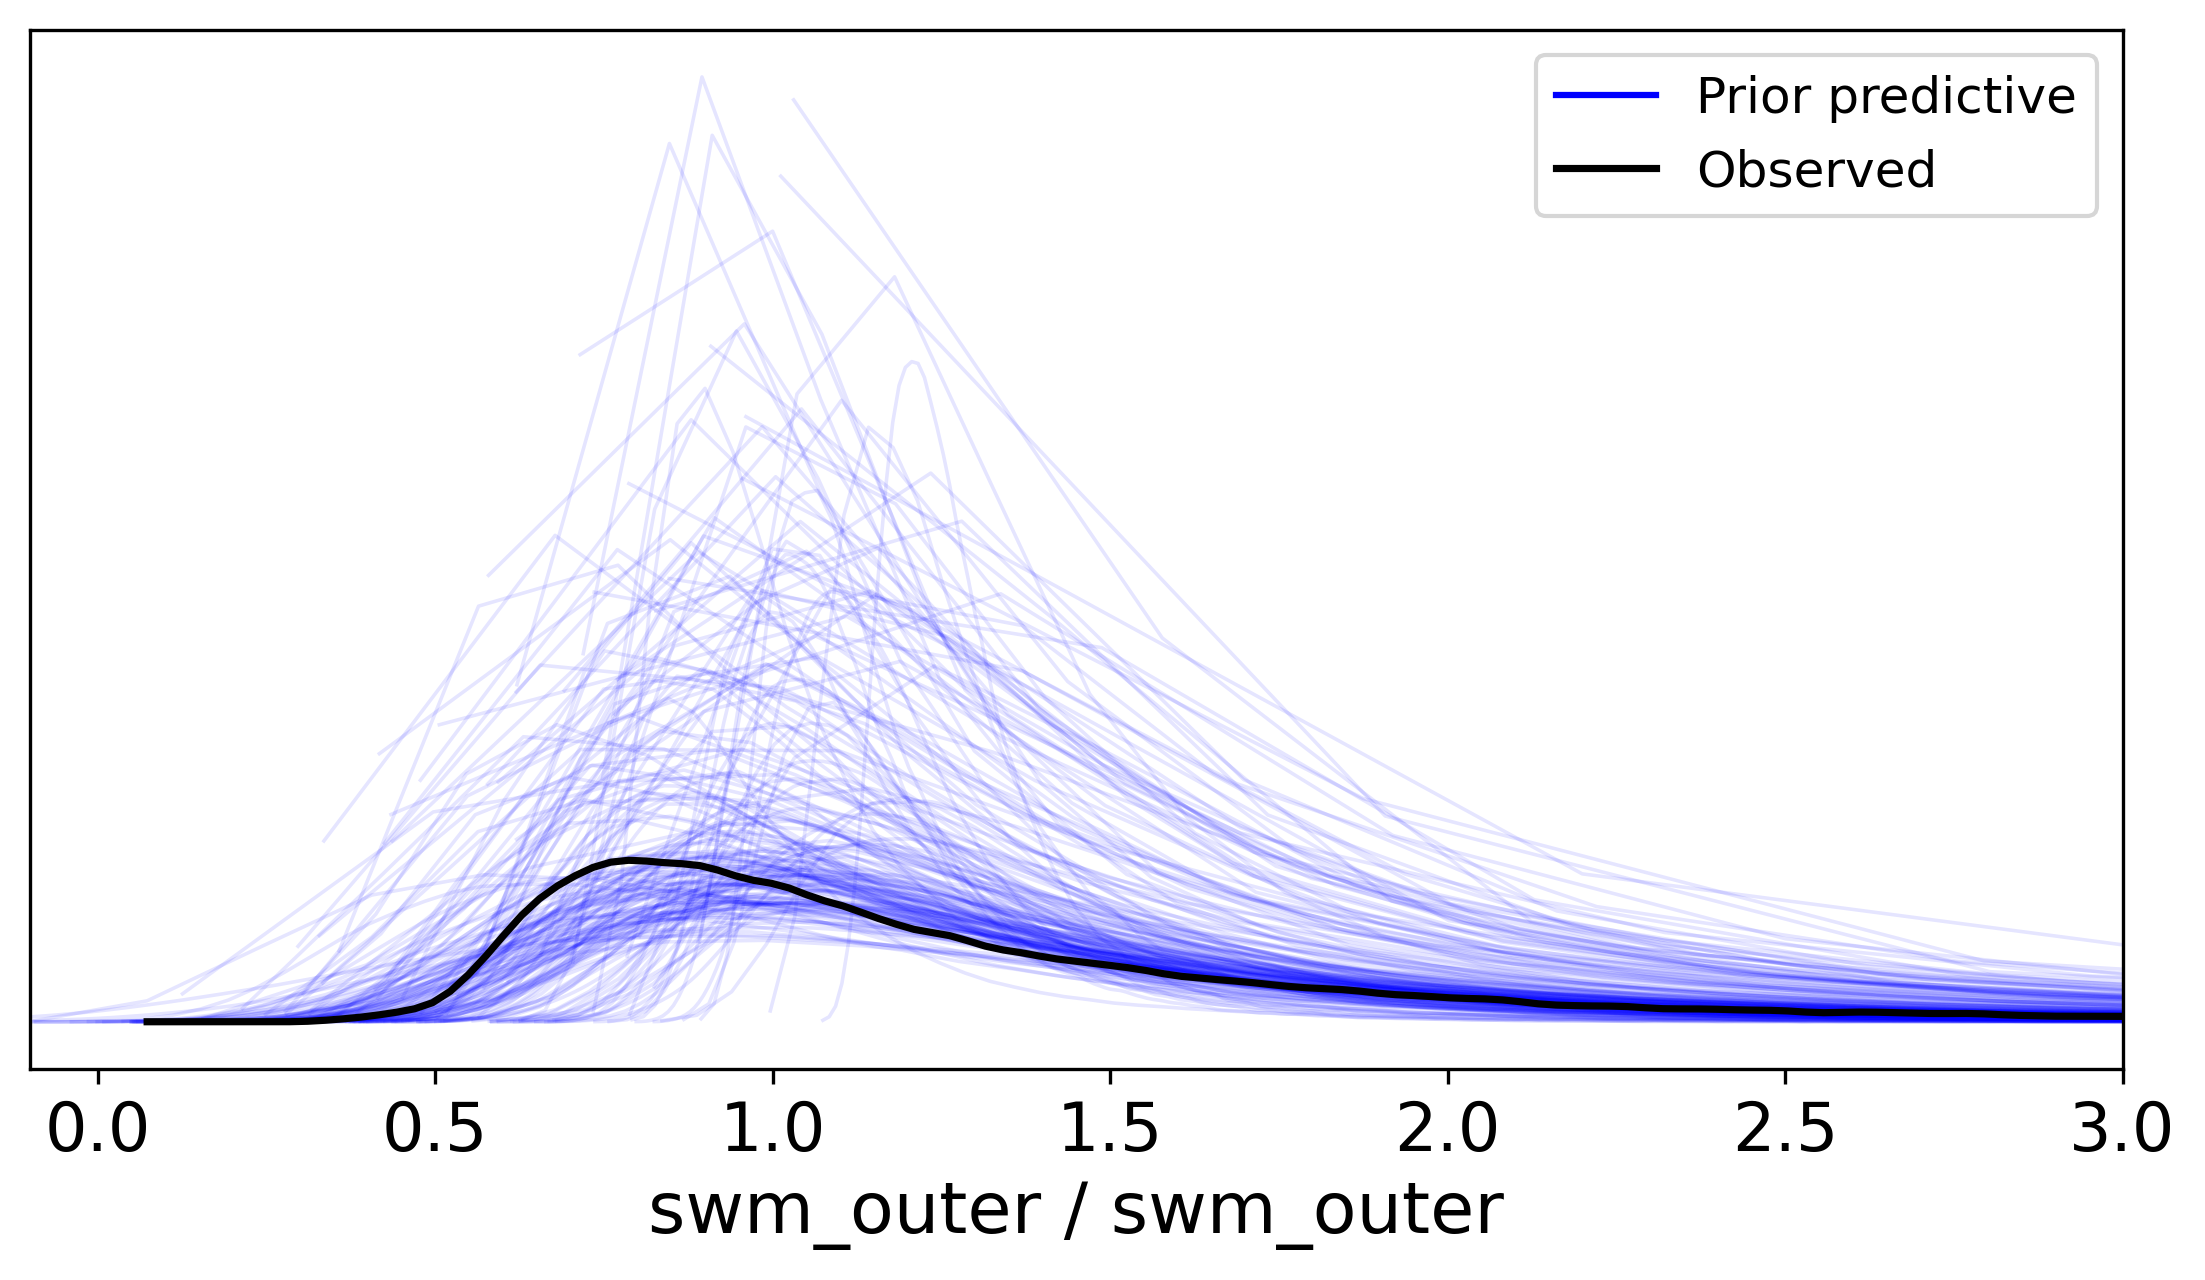

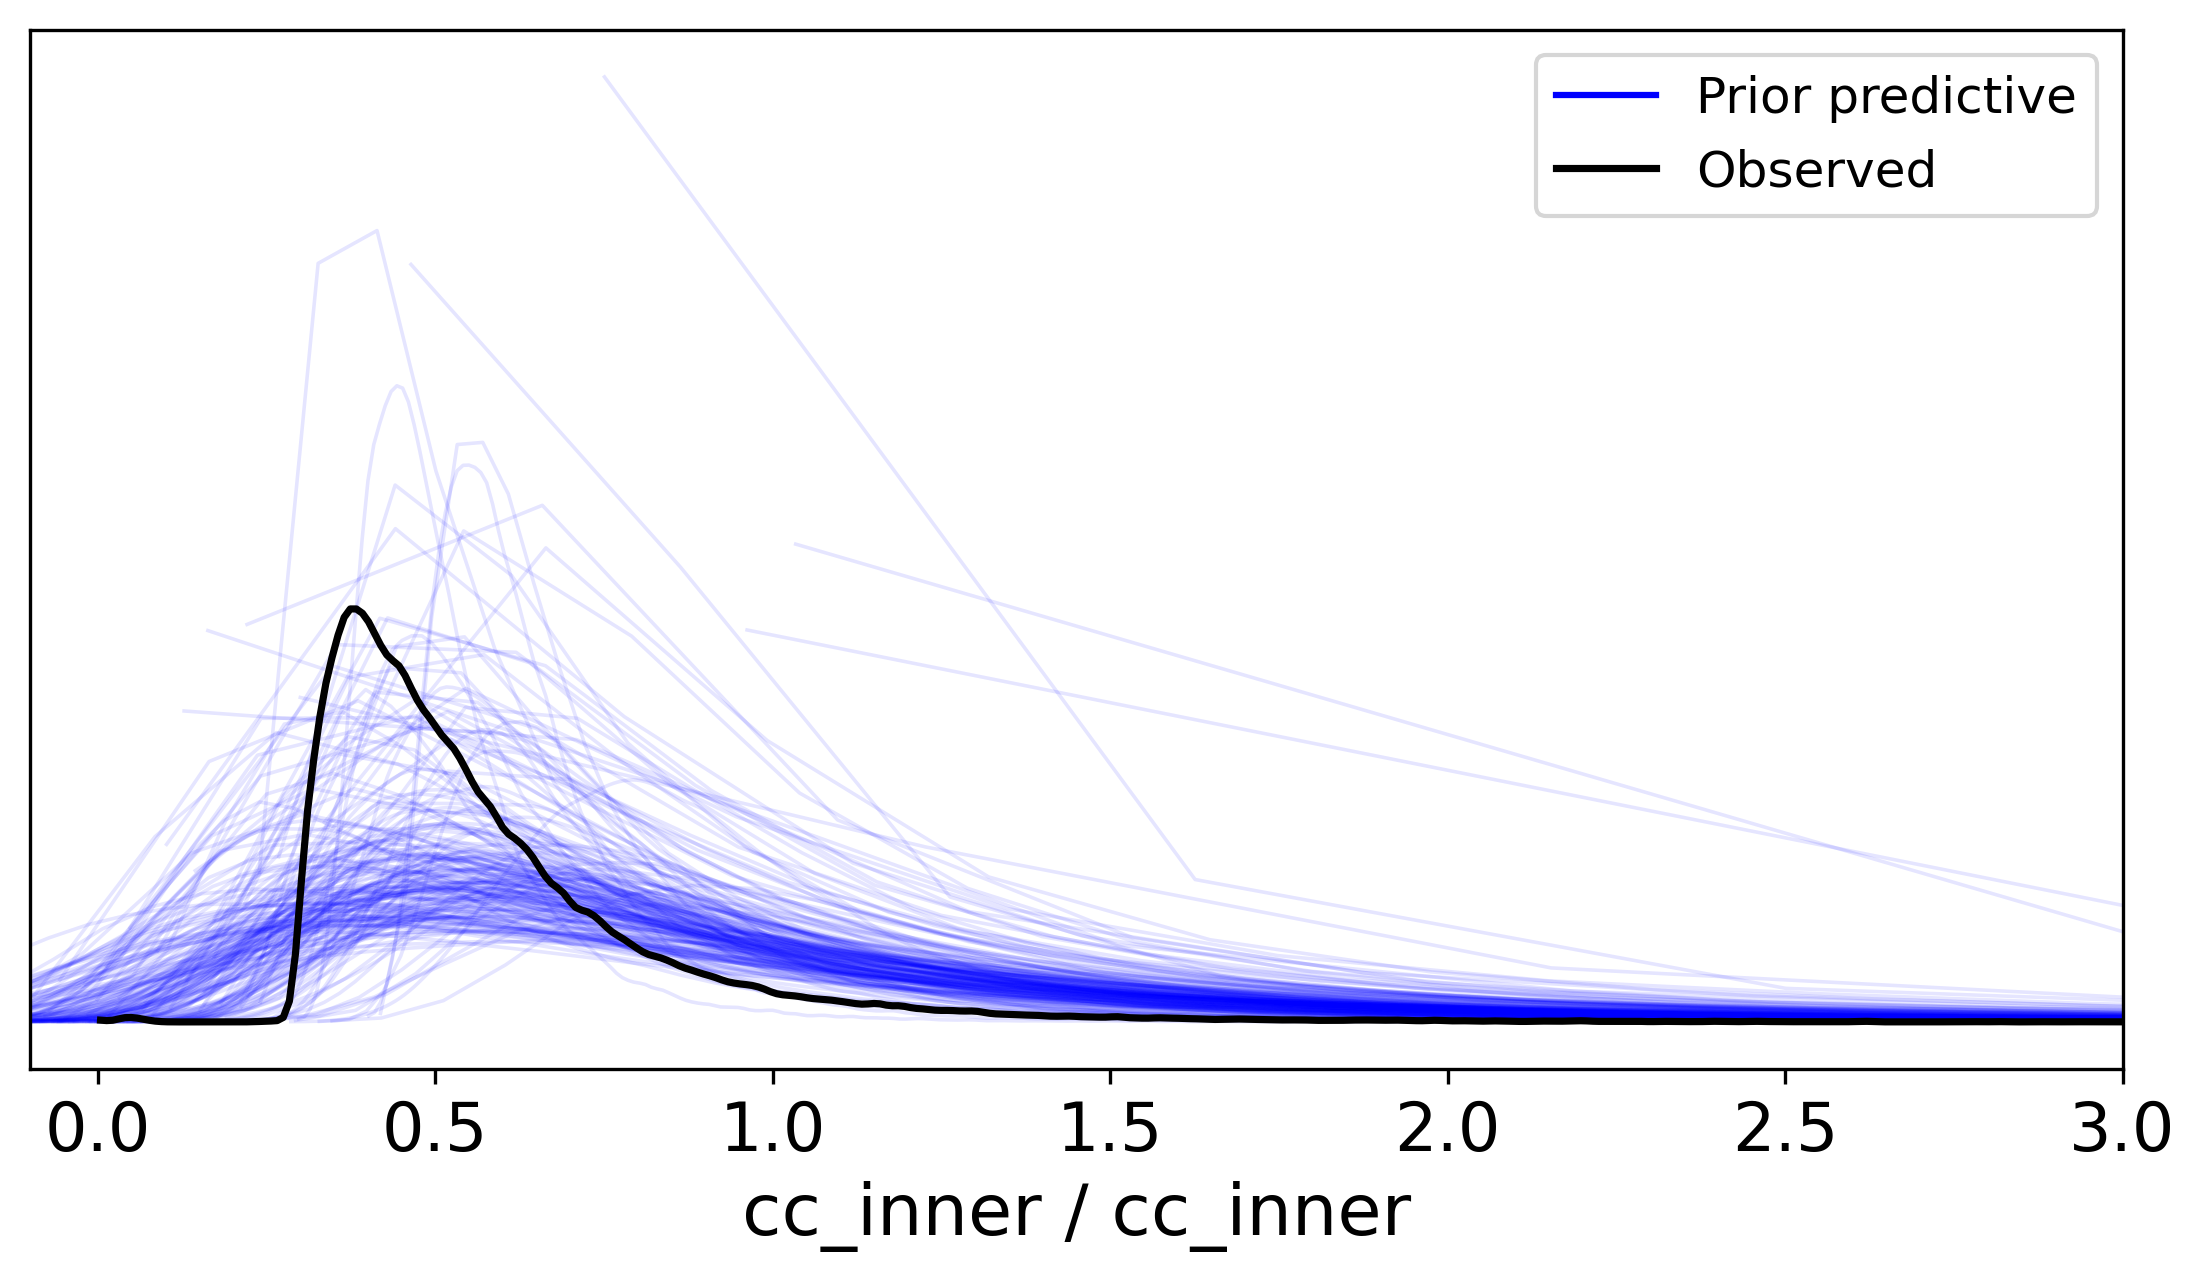

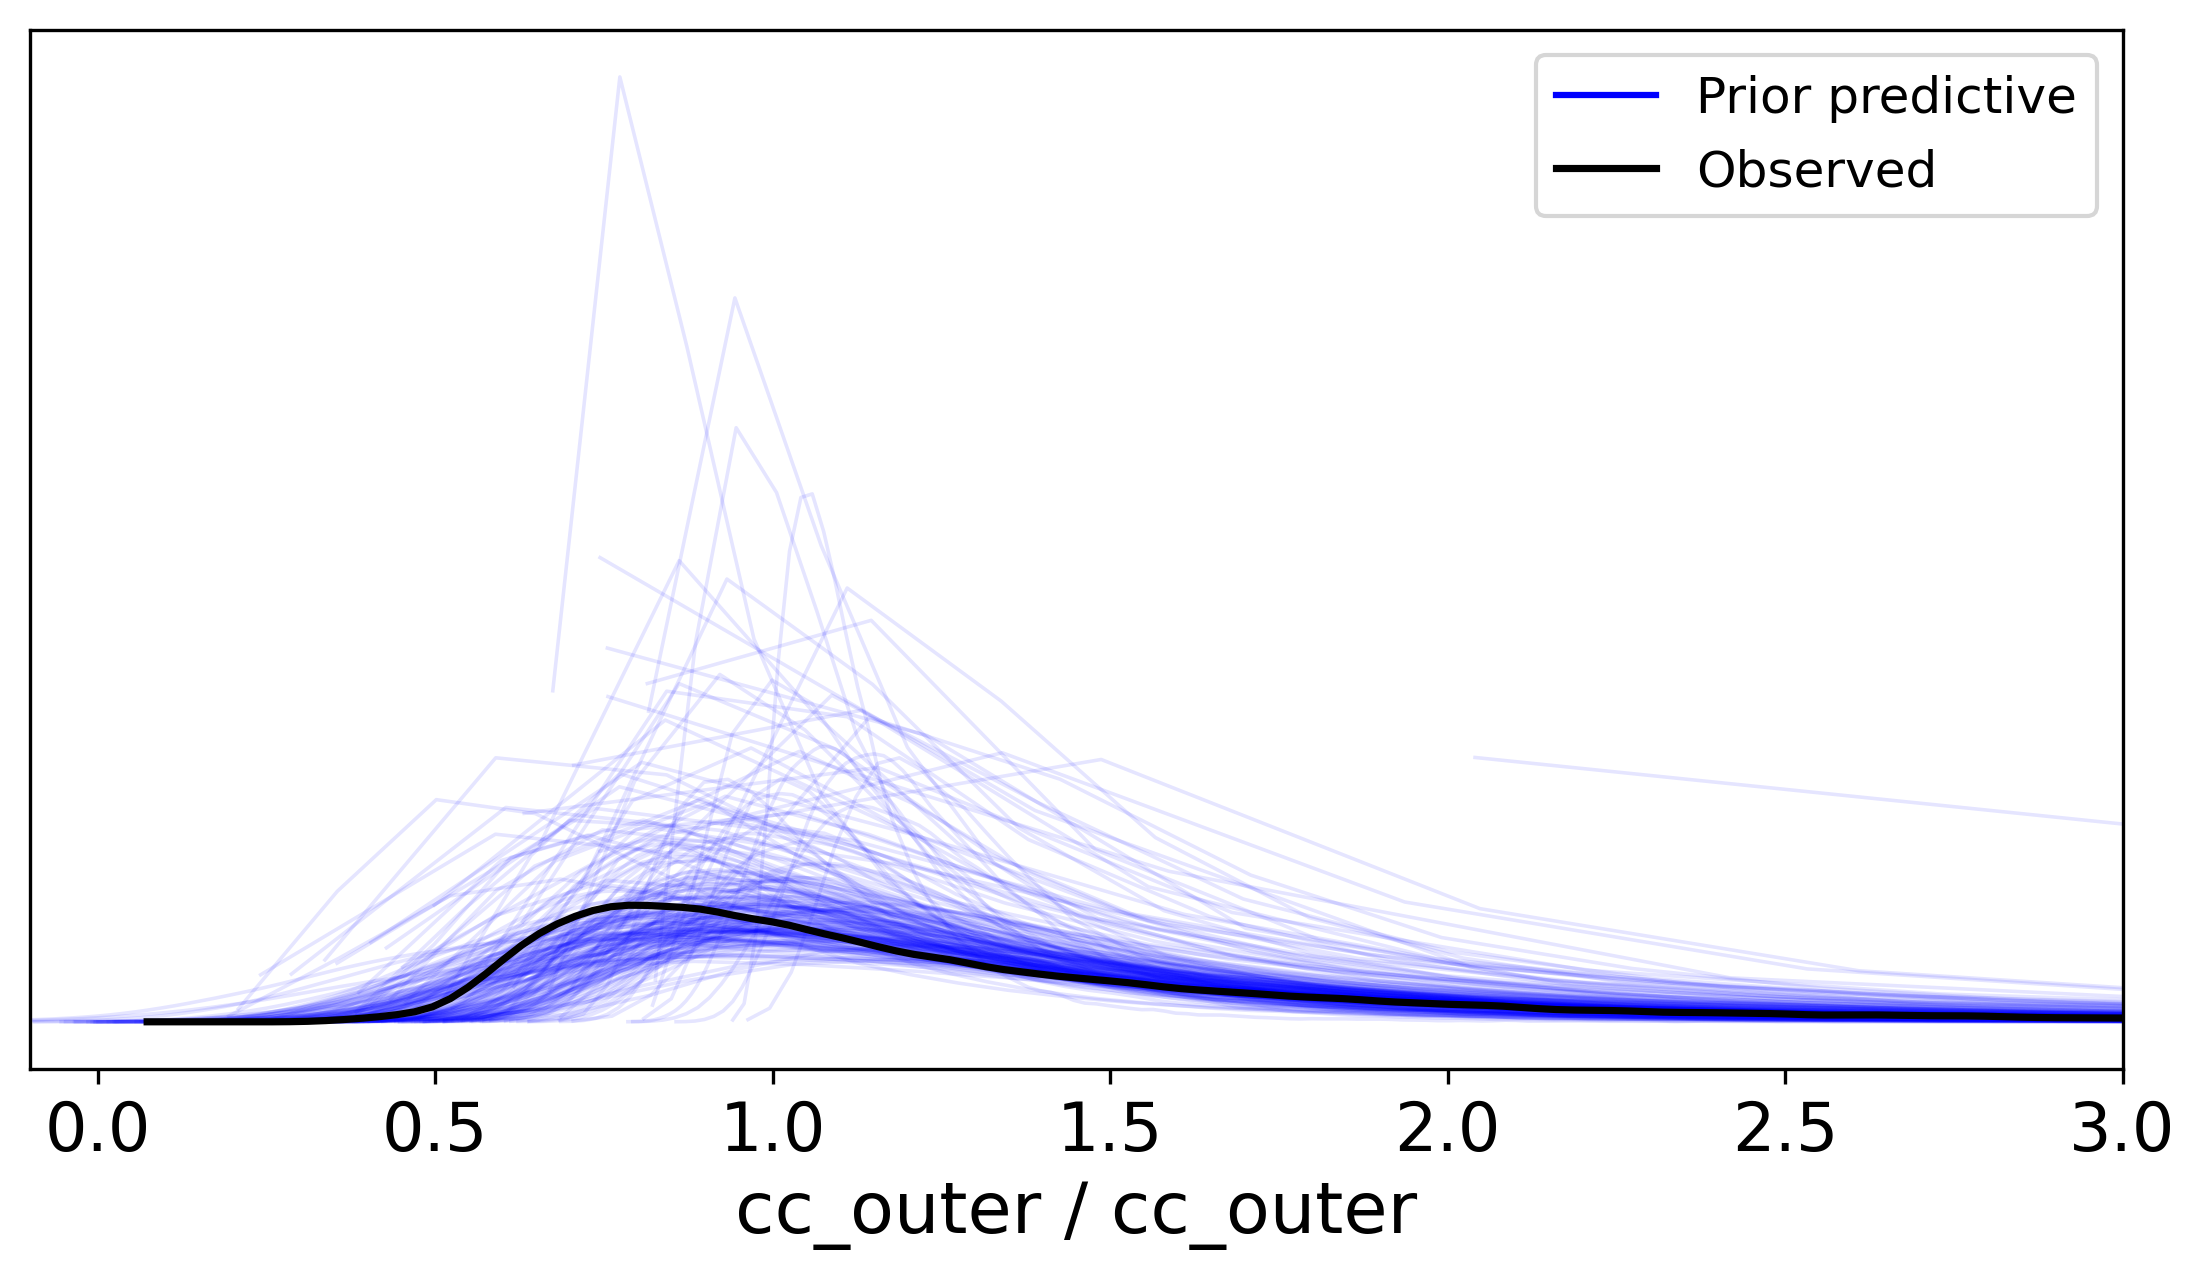

In [22]:
az.plot_ppc(trace_prior, group="prior", figsize=(9, 4.5),colors=['blue','black','orange'],alpha=0.1,var_names=["swm_inner",],mean=False)
plt.xlim(-0.1, 3)
plt.show()

az.plot_ppc(trace_prior, group="prior", figsize=(9, 4.5),colors=['blue','black','orange'],alpha=0.1,var_names=["swm_outer",],mean=False)
plt.xlim(-0.1, 3)
plt.show()

az.plot_ppc(trace_prior, group="prior", figsize=(9, 4.5),colors=['blue','black','orange'],alpha=0.1,var_names=["cc_inner",],mean=False)
plt.xlim(-0.1, 3)
plt.show()

az.plot_ppc(trace_prior, group="prior", figsize=(9, 4.5),colors=['blue','black','orange'],alpha=0.1,var_names=["cc_outer",],mean=False)
plt.xlim(-0.1, 3)
plt.show()

In [23]:
# Perform MCMC sampling
with model:
    trace = pm.sample(draws=4000,
                      tune=500,
                      chains=4,
                      cores=4,
                      random_seed=42,
                      # step=pm.HamiltonianMC(),
                    #   idata_kwargs={'log_likelihood':True},
                      # target_accept=0.9,
                      )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [swm_mu_inner, swm_sigma_inner, swm_xi_inner, cc_mu_inner, cc_sigma_inner, cc_xi_inner, swm_mu_outer, swm_sigma_outer, swm_xi_outer, cc_mu_outer, cc_sigma_outer, cc_xi_outer]


In [ ]:
# save inference data
trace.to_netcdf("trace_CCvsSWM_all.nc")

In [ ]:
# re-open inference data
trace = az.from_netcdf("trace_CCvsSWM_all.nc")

In [ ]:
# # for var_name in var_names:
# az.plot_forest(trace, var_names=["swm_mu_inner","cc_mu_inner"], combined=True, hdi_prob=0.95, r_hat=True)
# az.plot_forest(trace, var_names=["swm_mu_outer","cc_mu_outer"], combined=True, hdi_prob=0.95, r_hat=True)

In [ ]:
# Get the posterior mean and standard deviation of the parameters
swm_mean_mu_inner = np.mean(trace['posterior']['swm_mu_inner'])
swm_mean_sigma_inner = np.mean(trace['posterior']['swm_sigma_inner'])
swm_mean_xi_inner = np.mean(trace['posterior']['swm_xi_inner']*(-1))

swm_mean_mu_outer = np.mean(trace['posterior']['swm_mu_outer'])
swm_mean_sigma_outer = np.mean(trace['posterior']['swm_sigma_outer'])
swm_mean_xi_outer = np.mean(trace['posterior']['swm_xi_outer']*(-1))

cc_mean_mu_inner = np.mean(trace['posterior']['cc_mu_inner'])
cc_mean_sigma_inner = np.mean(trace['posterior']['cc_sigma_inner'])
cc_mean_xi_inner = np.mean(trace['posterior']['cc_xi_inner']*(-1))

cc_mean_mu_outer = np.mean(trace['posterior']['cc_mu_outer'])
cc_mean_sigma_outer = np.mean(trace['posterior']['cc_sigma_outer'])
cc_mean_xi_outer = np.mean(trace['posterior']['cc_xi_outer']*(-1))

In [ ]:
# Define the x range
x = np.linspace(0, np.max(data_swm["inner_axis_minor_length"]) * 2, 1000)

# Plotting GEV fittings for inner_axis_minor_length
plt.figure(figsize=(14, 6))

# Subplot for inner_axis_minor_length
ax = plt.subplot(1, 2, 1)

# Calculate PDFs
pdf_gev_swm_inner = genextreme.pdf(x, swm_mean_xi_inner,
                                   loc=swm_mean_mu_inner,
                                   scale=swm_mean_sigma_inner)

pdf_gev_cc_inner = genextreme.pdf(x, cc_mean_xi_inner,
                                  loc=cc_mean_mu_inner,
                                  scale=cc_mean_sigma_inner)

pdf_gev_swm_outer = genextreme.pdf(x, swm_mean_xi_outer,
                                   loc=swm_mean_mu_outer,
                                   scale=swm_mean_sigma_outer)

pdf_gev_cc_outer = genextreme.pdf(x, cc_mean_xi_outer,
                                  loc=cc_mean_mu_outer,
                                  scale=cc_mean_sigma_outer)

# Plot the curves and fill the area below
plt.plot(x, pdf_gev_swm_inner, label='SWM axons', alpha=0.6, color='darkorange')
plt.fill_between(x, 0, pdf_gev_swm_inner, color='darkorange', alpha=0.1)

plt.plot(x, pdf_gev_cc_inner, label='CC axons', alpha=0.6, color='blue')
plt.fill_between(x, 0, pdf_gev_cc_inner, color='blue', alpha=0.1)

plt.plot(x, pdf_gev_swm_outer, label='SWM outer fiber diameter', alpha=0.6, color='darkorange', ls="--")
plt.fill_between(x, 0, pdf_gev_swm_outer, color='darkorange', alpha=0.1)

plt.plot(x, pdf_gev_cc_outer, label='CC outer fiber diameter', alpha=0.6, color='blue', ls="--")
plt.fill_between(x, 0, pdf_gev_cc_outer, color='blue', alpha=0.1)

plt.xlim(0, 5)
plt.ylim(0, 2.5)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.legend()
plt.title('GEV (Means of Posterior for CC and SWM fibers)')
plt.xlabel('Diameter [µm]')
plt.ylabel('Posterior Density Function - PDF')
plt.show()

In [ ]:
# visualize raw data with fitted GEV -- axon diameters
fig, ax = plt.subplots(figsize=(8, 5*2/3))

bins = np.linspace(min(min(data_swm['inner_axis_minor_length']), min(data_cc['inner_axis_minor_length'])),
                   max(max(data_swm['inner_axis_minor_length']), max(data_cc['inner_axis_minor_length'])), 250)

# Plot for swm
ax.hist(data_swm['inner_axis_minor_length'], bins=bins, edgecolor='black', color='darkorange', alpha=0.4, label='SWM', density=True)
ax.axvline(data_swm['inner_axis_minor_length'].mean(), color='orange', linestyle='--', label='Mean (SWM)')

ax.plot(x, pdf_gev_swm_inner, label='GEV (SWM axons)', alpha=0.6, color='darkorange')

# Plot for cc
ax.hist(data_cc['inner_axis_minor_length'], bins=bins, edgecolor='black', color='darkblue', alpha=0.4, label='CC', density=True)
ax.axvline(data_cc['inner_axis_minor_length'].mean(), color='blue', linestyle='--', label='Mean (CC)')

ax.plot(x, pdf_gev_cc_inner, label='GEV (CC axons)', alpha=0.6, color='blue')

# Customize plot elements
ax.set_ylabel('Number of cells (normalized)')
ax.set_xlabel('Axon diameter [µm]')
ax.set_xlim(0.2,2)
ax.grid(True, linestyle='--', alpha=0.4, which='both')
ax.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.show()

print(f"Mean axon Diameter (CC): {data_cc['inner_axis_minor_length'].mean()}")
print(f"Mean axon Diameter (SWM): {data_swm['inner_axis_minor_length'].mean()}")
print(f"Ratio SWM/CC: {data_swm['inner_axis_minor_length'].mean()/data_cc['inner_axis_minor_length'].mean()}")


In [ ]:
# visualize raw data with fitted GEV -- outer fiber diameter
fig, ax = plt.subplots(figsize=(8, 5*2/3))

bins = np.linspace(min(min(data_swm['outer_axis_minor_length']), min(data_cc['outer_axis_minor_length'])),
                   max(max(data_swm['outer_axis_minor_length']), max(data_cc['outer_axis_minor_length'])), 250)

# Plot for swm
ax.hist(data_swm['outer_axis_minor_length'], bins=bins, edgecolor='black', color='darkorange', alpha=0.4, label='SWM', density=True)
ax.axvline(data_swm['outer_axis_minor_length'].mean(), color='orange', linestyle='--', label='Mean (SWM)')
ax.plot(x, pdf_gev_swm_outer, label='GEV (SWM outer fiber diameter)', alpha=0.6, color='darkorange',)

# Plot for cc
ax.hist(data_cc['outer_axis_minor_length'], bins=bins, edgecolor='black', color='darkblue', alpha=0.4, label='CC', density=True)
ax.axvline(data_cc['outer_axis_minor_length'].mean(), color='blue', linestyle='--', label='Mean (CC)')
ax.plot(x, pdf_gev_cc_outer, label='GEV (CC outer fiber diameter)', alpha=0.6, color='blue',)

# Customize plot elements
ax.set_ylabel('Number of cells (normalized)')
ax.set_xlabel('Outer fiber diameter [µm]')
ax.set_xlim(0.2,4)
ax.grid(True, linestyle='--', alpha=0.4, which='both')
ax.legend()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.show()

print(f"Mean myelin Diameter (CC): {data_cc['outer_axis_minor_length'].mean()}")
print(f"Mean myelin Diameter (SWM): {data_swm['outer_axis_minor_length'].mean()}")
print(f"Ratio SWM/CC: {data_swm['outer_axis_minor_length'].mean()/data_cc['outer_axis_minor_length'].mean()}")


In [ ]:
# Calculate conduction velocity according to Rushton et al (1951) Knösche (2019) 
cc_speeds = [] # initialize empty list
for index, row in data_cc.iterrows():
    axon_diameter = row['inner_axis_minor_length']
    gratio = row['gratio']
    if gratio == 0.0:
        continue
    velocity = calculate_connection_velocity_rushton(axon_diameter, gratio)
    cc_speeds.append(velocity)

swm_speeds = [] # initialize empty list
for index, row in data_swm.iterrows():
    axon_diameter = row['inner_axis_minor_length']
    gratio = row['gratio']
    if gratio == 0.0:
        continue
    velocity = calculate_connection_velocity_rushton(axon_diameter, gratio)
    swm_speeds.append(velocity)


In [ ]:
def filter_fastest_10_percent(speeds):
    speeds_sorted = sorted(speeds)
    threshold_index = int(len(speeds_sorted) * 0.9)
    return speeds_sorted[:threshold_index]

#distances to cover, in m
# distance_m1s1 = 0.065 
# distance_callosal_m1m1 = 0.135
distance_m1s1 = 0.05
distance_callosal_m1m1 = 0.1104

swm_speeds_slowest90 = filter_fastest_10_percent(swm_speeds)
# cc_speeds
np.mean(swm_speeds_slowest90)
# np.mean(cc_speeds)

# calculate latency in seconds
latency_m1s1 = distance_m1s1/np.mean(swm_speeds_slowest90)
latency_callosal_m1m1 = distance_callosal_m1m1/np.mean(cc_speeds)
print(f"Latency from M1 to S1 via U fibers: {latency_m1s1*1000} milliseconds")
print(f"Latency from M1 (left) to M1 (right) via callosal fibers: {latency_callosal_m1m1*1000} milliseconds")

In [ ]:
# Function to format the colorbar ticks with exponentiated values
def exp_format_func(value,ticker):
    return f'{np.exp(value):.2f}'

def autolabel(rects,panel):
    """Attach a text label above each bar in *rects*, displaying its height and standard deviation."""
    for rect in rects:
        height = rect.get_height()
        label = f"{height:.2f}".lstrip('0')
        ax[panel].annotate(label,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Initialize Figure 2
ax = plt.figure(figsize=(8.5*1.2,11*1.2),dpi=300).subplot_mosaic(
    """
    AAABBB
    AAABBB
    AAABBB
    CCCDDD
    CCCDDD
    CCCDDD
    EEEHHH
    EEEHHH
    EEEHHH
    """)

# A
bins = np.linspace(min(min(data_swm['inner_axis_minor_length']), min(data_cc['inner_axis_minor_length'])),
                   max(max(data_swm['inner_axis_minor_length']), max(data_cc['inner_axis_minor_length'])), 150)

# Plot for swm
ax["A"].hist(data_swm['inner_axis_minor_length'], bins=bins, edgecolor='black', color='darkorange', alpha=0.4, label='SWM', density=True)
# ax["A"].axvline(data_swm['inner_axis_minor_length'].mean(), color='orange', linestyle='--', label='Mean (SWM)')
ax["A"].plot(x, pdf_gev_swm_inner, label='GEV (SWM axons)', alpha=0.8, color='darkorange')

# ["A"]Plot for cc
ax["A"].hist(data_cc['inner_axis_minor_length'], bins=bins, edgecolor='black', color='darkblue', alpha=0.4, label='CC', density=True)
# ax["A"].axvline(data_cc['inner_axis_minor_length'].mean(), color='blue', linestyle='--', label='Mean (CC)')

ax["A"].plot(x, pdf_gev_cc_inner, label='GEV (CC axons)', alpha=0.8, color='blue')

# ["A"]Customize plot elements
ax["A"].set_ylabel('Number of cells (normalized)')
ax["A"].set_xlabel('Axon diameter [µm]')
ax["A"].set_xlim(0.2,2)
ax["A"].grid(True, linestyle='--', alpha=0.4, which='both')
ax["A"].legend()
ax["A"].spines['right'].set_visible(False)
ax["A"].spines['top'].set_visible(False)

# B
# bins = np.linspace(min(min(data_swm['outer_axis_minor_length']), min(data_cc['outer_axis_minor_length'])),
#                    max(max(data_swm['outer_axis_minor_length']), max(data_cc['outer_axis_minor_length'])), 150)
bins = bins*2

# Plot for swm
ax["B"].hist(data_swm['outer_axis_minor_length'], bins=bins, edgecolor='black', color='darkorange', alpha=0.4, label='SWM', density=True)
# ax["B"].axvline(data_swm['outer_axis_minor_length'].mean(), color='orange', linestyle='--', label='Mean (SWM)')
ax["B"].plot(x, pdf_gev_swm_outer, label='GEV (SWM outer fiber diameter)', alpha=0.8, color='darkorange',linestyle="--")

# ["B"]Plot for cc
ax["B"].hist(data_cc['outer_axis_minor_length'], bins=bins, edgecolor='black', color='darkblue', alpha=0.4, label='CC', density=True)
# ax["B"].axvline(data_cc['outer_axis_minor_length'].mean(), color='blue', linestyle='--', label='Mean (CC)')
ax["B"].plot(x, pdf_gev_cc_outer, label='GEV (CC outer fiber diameter)', alpha=0.8, color='blue',linestyle="--")

# ["B"]Customize plot elements
ax["B"].set_ylabel('Number of cells (normalized)')
ax["B"].set_xlabel('Outer fiber diameter [µm]')
ax["B"].set_xlim(0.2,4)
ax["B"].grid(True, linestyle='--', alpha=0.4, which='both')
ax["B"].legend()

ax["B"].spines['right'].set_visible(False)
ax["B"].spines['top'].set_visible(False)

# C
# Extracting data for swm
x_swm = data_swm['inner_axis_minor_length'].values.reshape(-1, 1)
y_swm = data_swm['gratio'].values.reshape(-1, 1)

x_swm_sub = x_swm[::5,0]# use a subset only
y_swm_sub = y_swm[::5,0]

# Compute KDE
values = np.vstack([x_swm_sub, y_swm_sub])
kde = gaussian_kde(values)
z = np.log(kde(values))

# Create the plot
ax["C"].tricontour(x_swm_sub, y_swm_sub, z, levels=22, linewidths=0.75, colors='k')
cntr = ax["C"].tricontourf(x_swm_sub, y_swm_sub, z, levels=22,cmap="magma")
# Colorbar and scatter plot
ax["C"].set(xlim=(0, 5), ylim=(0, 1))
ax["C"].set_facecolor('black')
ax["C"].set_ylabel('g-ratio')
ax["C"].set_xlabel('Axon diameter [µm]')
ax["C"].set_title('Axon diameter vs g-ratio - SWM')

# D
# Extracting data for cc
x_cc = data_cc['inner_axis_minor_length'].values.reshape(-1, 1)
y_cc = data_cc['gratio'].values.reshape(-1, 1)

x_cc_sub = x_cc[::5,0]# use a subset only
y_cc_sub = y_cc[::5,0]

# Compute KDE
values = np.vstack([x_cc_sub, y_cc_sub])
kde = gaussian_kde(values)
z = np.log(kde(values))

# Create the plot
ax["D"].tricontour(x_cc_sub, y_cc_sub, z, levels=22, linewidths=0.75, colors='k')
cntr = ax["D"].tricontourf(x_cc_sub, y_cc_sub, z, levels=22,cmap="magma")
ax["D"].set(xlim=(0, 5), ylim=(0, 1))
ax["D"].set_facecolor('black')
ax["D"].set_ylabel('g-ratio')
ax["D"].set_xlabel('Axon diameter [µm]')
ax["D"].set_title('Axon diameter vs g-ratio - CC')

# Add a colorbar with exponentiated values
cbar = fig.colorbar(cntr, ax=ax["D"], orientation='vertical', fraction=0.04,aspect=60)
cbar.formatter = FuncFormatter(exp_format_func)
cbar.update_ticks()

# E
# plot g ratio distributions
swm_mean = data_swm['gratio'].mean()
cc_mean = data_cc['gratio'].mean()
ax["E"].hist(data_swm['gratio'], bins=40, edgecolor='black', color='darkorange', alpha=0.4, label='SWM', density=True)
ax["E"].axvline(swm_mean, color='darkorange', linestyle='--',alpha = 0.6, label='Mean (SWM)')
ax["E"].hist(data_cc['gratio'], bins=40, edgecolor='black', color='darkblue', alpha=0.4, label='CC', density=True)
ax["E"].axvline(cc_mean, color='darkblue', linestyle='--',alpha = 0.6, label='Mean (CC)')
ax["E"].set_ylabel('Number of cells (normalized)')
ax["E"].set_xlabel('g-ratio')
ax["E"].set_xlim((0,1))
ax["E"].grid(True, linestyle='--', alpha=0.4, which='both')
ax["E"].legend()
ax["E"].spines['right'].set_visible(False)
ax["E"].spines['top'].set_visible(False)

#H
ax["H"].hist(swm_speeds, bins=np.linspace(0, 16, 55), edgecolor='black', color='darkorange', alpha=0.4, label='SWM', density=True)
ax["H"].axvline(np.mean(swm_speeds), color='darkorange', linestyle='--',alpha = 0.6, label='Mean (SWM)')
ax["H"].hist(cc_speeds, bins=np.linspace(0, 16, 55), edgecolor='black', color='darkblue', alpha=0.4, label='CC', density=True)
ax["H"].axvline(np.mean(cc_speeds), color='darkblue', linestyle='--',alpha = 0.6, label='Mean (CC)')

# set parameters for plot
ax["H"].set_ylabel('Number of cells (normalized)')
ax["H"].set_xlabel('Estimated conduction velocity [m/s]')
ax["H"].set_xlim((0,12))
ax["H"].grid(True, linestyle='--', alpha=0.4, which='both')
ax["H"].legend()
ax["H"].spines['right'].set_visible(False)
ax["H"].spines['top'].set_visible(False)

# add A-F labels (thanks pylustrator!!)
plt.figure(1).ax_dict = {ax.get_label(): ax for ax in plt.figure(1).axes}
getattr(plt.figure(1), '_pylustrator_init', lambda: ...)()
plt.figure(1).ax_dict["A"].text(-0.1558+0.03, 1.0202+0.03, 'a', transform=plt.figure(1).ax_dict["A"].transAxes, fontsize=16., weight='bold')  # id=plt.figure(1).ax_dict["A"].texts[0].new
plt.figure(1).ax_dict["B"].text(-0.1073+0.03, 1.0202+0.03, 'b', transform=plt.figure(1).ax_dict["B"].transAxes, fontsize=16., weight='bold')  # id=plt.figure(1).ax_dict["B"].texts[0].new
plt.figure(1).ax_dict["C"].text(-0.1558+0.03, 1.0215+0.03, 'c', transform=plt.figure(1).ax_dict["C"].transAxes, fontsize=16., weight='bold')  # id=plt.figure(1).ax_dict["C"].texts[0].new
plt.figure(1).ax_dict["D"].text(-0.1073+0.03, 1.0215+0.03, 'd', transform=plt.figure(1).ax_dict["D"].transAxes, fontsize=16., weight='bold')  # id=plt.figure(1).ax_dict["D"].texts[0].new
plt.figure(1).ax_dict["E"].text(-0.1073+0.03, 1.0215+0.03, 'e', transform=plt.figure(1).ax_dict["E"].transAxes, fontsize=16., weight='bold')  # id=plt.figure(1).ax_dict["E"].texts[6].new
plt.figure(1).ax_dict["H"].text(-0.1073+0.03, 1.0175+0.03, 'f', transform=plt.figure(1).ax_dict["H"].transAxes, fontsize=16., weight='bold')  # id=plt.figure(1).ax_dict["F"].texts[0].new
plt.tight_layout()
plt.show()

In [ ]:
### figure 3
ax = plt.figure(figsize=(8.5*1.2,11*1.2/3),dpi=300).subplot_mosaic(
    """
    AAABC.
    AAABCD
    AAABCD
    AAABCD
    AAABCD
    """)

# Plot GEV curves and fill the area below
ax["A"].plot(x, pdf_gev_swm_inner, label='SWM axon diameter', alpha=0.6, color='darkorange')
ax["A"].fill_between(x, 0, pdf_gev_swm_inner, color='darkorange', alpha=0.1)

ax["A"].plot(x, pdf_gev_cc_inner, label='CC axon diameter', alpha=0.6, color='blue')
ax["A"].fill_between(x, 0, pdf_gev_cc_inner, color='blue', alpha=0.1)

ax["A"].plot(x, pdf_gev_swm_outer, label='SWM outer fiber diameter', alpha=0.6, color='darkorange', ls="--")
ax["A"].fill_between(x, 0, pdf_gev_swm_outer, color='darkorange', alpha=0.1)

ax["A"].plot(x, pdf_gev_cc_outer, label='CC outer fiber diameter', alpha=0.6, color='blue', ls="--")
ax["A"].fill_between(x, 0, pdf_gev_cc_outer, color='blue', alpha=0.1)

# set parameters for plot
ax["A"].set_xlim(0, 3)
ax["A"].set_ylim(0, 2.5)
ax["A"].spines['right'].set_visible(False)
ax["A"].spines['top'].set_visible(False)
ax["A"].legend()
ax["A"].set_title('GEV distributions (Means of Posterior)')
ax["A"].set_xlabel('Diameter [µm]')
ax["A"].set_ylabel('Posterior Density Function - PDF')
ax["A"].grid(True, linestyle='--', alpha=0.4, which='both')

cc_mu_axon_mean = trace["posterior"]["cc_mu_inner"].mean()
cc_si_axon_mean = trace["posterior"]["cc_sigma_inner"].mean()
cc_xi_axon_mean = trace["posterior"]["cc_xi_inner"].mean()
cc_mu_myelin_mean = trace["posterior"]["cc_mu_outer"].mean()
cc_si_myelin_mean = trace["posterior"]["cc_sigma_outer"].mean()
cc_xi_myelin_mean = trace["posterior"]["cc_xi_outer"].mean()

swm_mu_axon_mean = trace["posterior"]["swm_mu_inner"].mean()
swm_si_axon_mean = trace["posterior"]["swm_sigma_inner"].mean()
swm_xi_axon_mean = trace["posterior"]["swm_xi_inner"].mean()
swm_mu_myelin_mean = trace["posterior"]["swm_mu_outer"].mean()
swm_si_myelin_mean = trace["posterior"]["swm_sigma_outer"].mean()
swm_xi_myelin_mean = trace["posterior"]["swm_xi_outer"].mean()

# Data preparation
labels = ['SWM', 'CC']

e_x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

rects1_a = ax["B"].bar(e_x - width/2, [cc_mu_axon_mean,cc_mu_myelin_mean], width, label='CC', yerr=((0.5574-0.5547)/2,(1.158-1.152)/2), capsize=5,alpha=0.6,color="yellowgreen")
rects1_m = ax["B"].bar(e_x + width/2, [swm_mu_axon_mean,swm_mu_myelin_mean], width, label='SWM', yerr=((0.4566-0.4546)/2,(0.9333-0.9288)/2), capsize=5,alpha=0.6,color="darkgreen")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax["B"].set_ylabel('GEV Posterior Parameter Values [mean+-99% HDI]')
ax["B"].set_xlabel(r'$\mu$')
ax["B"].set_xticks(e_x)
ax["B"].set_xticklabels(labels)
ax["B"].yaxis.grid(True,alpha=0.4)

autolabel(rects1_a,"B")# axon
autolabel(rects1_m,"B")# myelin

ax["B"].spines['top'].set_visible(False)
ax["B"].spines['right'].set_visible(False)

# F
rects2_a = ax["C"].bar(e_x - width/2, [cc_si_axon_mean,cc_si_myelin_mean], width, label='CC', yerr=((0.2232-0.2211)/2,(0.4553-0.4505)/2), capsize=5,alpha=0.6,color="yellowgreen")
rects2_m = ax["C"].bar(e_x + width/2, [swm_si_axon_mean,swm_si_myelin_mean], width, label='SWM', yerr=((0.1536-0.1522)/2,(0.3477-0.344)/2), capsize=5,alpha=0.6,color="darkgreen")

ax["C"].set_xlabel(r'$\sigma$')
ax["C"].set_xticks(e_x)
ax["C"].set_xticklabels(labels)
ax["C"].yaxis.grid(True,alpha=0.4)

autolabel(rects2_a,"C")# axon
autolabel(rects2_m,"C")# myelin

ax["C"].spines['top'].set_visible(False)
ax["C"].spines['right'].set_visible(False)

#G
rects3_a = ax["D"].bar(e_x - width/2, [cc_xi_axon_mean,cc_xi_myelin_mean], width, label='CC', yerr=((0.2109-0.2045)/2,(0.2707-0.2614)/2), capsize=5,alpha=0.6,color="yellowgreen")
rects3_m = ax["D"].bar(e_x + width/2, [swm_xi_axon_mean,swm_xi_myelin_mean], width, label='SWM', yerr=((0.1126-0.1069)/2,(0.2582-0.2495)/2), capsize=5,alpha=0.6,color="darkgreen")

ax["D"].set_xlabel(r'$\xi$')
ax["D"].set_xticks(e_x)
ax["D"].set_xticklabels(labels)
ax["D"].yaxis.grid(True,alpha=0.4)
autolabel(rects3_a,"D")# axon
autolabel(rects3_m,"D")# myelin
ax["D"].spines['top'].set_visible(False)
ax["D"].spines['right'].set_visible(False)
# ax["G"].legend(loc='upper right',)

plt.figure(1).ax_dict = {ax.get_label(): ax for ax in plt.figure(1).axes}
getattr(plt.figure(1), '_pylustrator_init', lambda: ...)()
plt.figure(1).ax_dict["A"].text(-0.1558+0.03, 1.0202+0.03, 'a', transform=plt.figure(1).ax_dict["A"].transAxes, fontsize=16., weight='bold')  # id=plt.figure(1).ax_dict["A"].texts[0].new
plt.figure(1).ax_dict["B"].text(-0.1073+0.03, 1.0202+0.03, 'b', transform=plt.figure(1).ax_dict["B"].transAxes, fontsize=16., weight='bold')  # id=plt.figure(1).ax_dict["B"].texts[0].new

plt.tight_layout()
plt.show()

In [ ]:
bins

In [ ]:
trace["posterior"]

In [ ]:
print(f"Mean speed for CC: {np.mean(cc_speeds)}")
print(f"Mean speed for SWM: {np.mean(swm_speeds)}")
print(f"Ratio of CC/SWM mean speeds: {np.mean(cc_speeds)/np.mean(swm_speeds)}")

In [ ]:
az.summary(trace,var_names=['difference of mu (fibers)',
                            'difference of sigma (fibers)',
                            'difference of xi (fibers)',
                            'difference of mu (myelination)',
                            'difference of sigma (myelination)',
                            'difference of xi (myelination)'],)
                # round_to=2)
                            
# print('') 

In [ ]:
az.hdi(trace,var_names=['swm_mu_inner',
                            'swm_mu_outer',
                            'cc_mu_inner',
                            'cc_mu_outer',
                            'swm_sigma_inner',
                            'swm_sigma_outer',
                            'cc_sigma_inner',
                            'cc_sigma_outer',
                            'swm_xi_inner',
                            'swm_xi_outer',
                            'cc_xi_inner',
                            'cc_xi_outer',], hdi_prob = 0.99).values()

In [ ]:
az.summary(trace,var_names=['swm_mu_inner',
                            'swm_mu_outer',
                            'cc_mu_inner',
                            'cc_mu_outer',
                            'swm_sigma_inner',
                            'swm_sigma_outer',
                            'cc_sigma_inner',
                            'cc_sigma_outer',
                            'swm_xi_inner',
                            'swm_xi_outer',
                            'cc_xi_inner',
                            'cc_xi_outer',],)
                # round_to=2)
                            
# print('') 

In [ ]:
plt.figure()
axes = az.plot_trace(trace,var_names=['cc_mu_inner','cc_xi_outer',
                                      'swm_mu_outer','swm_sigma_inner',],
                                      figsize=(12,8),
                                      compact=True,
                                      combined=False)
plt.tight_layout()
i=0
for ax in axes.flatten():#
    i+=1
    if i //2 == 0:
        ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.3f'))
        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.3f'))
plt.show()